In [114]:
from numpy  import*
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm,os
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.integrate import odeint
from scipy import linalg
import time
from numpy.linalg import det, inv, svd, norm
import numpy as np

### The Runge-Kutta numerical integration method.

In [115]:
def Runge_Kutta(to, tEnd, yo, tau, f, p):
    """Approximates the solution to a system of first-order ordinary differential equations
    using the fourth-order Runge-Kutta method.

    Args:
        to (float): Initial time.
        tEnd (float): Final time.
        yo (float): Initial condition for the dependent variable.
        tau (float): Step size.
        f (function): A function that calculates the derivative of the dependent variable
            with respect to time.
        p (dict): A dictionary containing any parameters required by the derivative function.

    Returns:
        array: An array containing the estimated values of the dependent variable at each time step.
    """

    def increment(f, t, y, tau, p):
        """Computes the weighted average of the derivatives at each of the intermediate points for a given time step.

        Returns:
            float: The weighted average of the derivatives at each of the intermediate points.
        """
        k1 = tau*f(t,y, p)
        k2 = tau*f(t+(1/4)*tau,y+(1/4)*k1, p)
        k3 = tau *f(t+(3/8)*tau,y+(3/32)*k1+(9/32)*k2, p)
        k4 = tau*f(t+(12/13)*tau,y+(1932/2197)*k1-(7200/2197)*k2+(7296/2197)*k3, p)
        k5 = tau*f(t+tau,y+(439/216)*k1-8*k2+(3680/513)*k3 -(845/4104)*k4, p)
        k6 = tau*f(t+(1/2)*tau,y-(8/27)*k1+2*k2-(3544/2565)*k3 +(1859/4104)*k4-(11/40)*k5, p)
        return (16/135)*k1+(6656/12825)*k3+(28561/56430)*k4-(9/50)*k5+(2/55)*k6
          
        
    y = [yo]
    while True:
        if tau > 0: tau = min(tau, tEnd - to)
        else: tau = max(tau, tEnd-to)
        to = to + tau
        if to == tEnd: break
        yo = yo + increment(f, to, yo, tau, p)
        y.append(yo)
    return array(y)

In [116]:
def calc_function(t, y, lambda_):

    f = np.zeros(4)

    p_ext = 1.17
    V0 = 87

    T, c1, c2, I, r1, r2 = [1, lambda_, 1.1, 1.13, 0.61, 0.93]

    # The first derivative for the first vessel
    f[0] = y[1]                                                 

    # The second derivative for the second vessel
    f[1] = round(-r1*T/I*y[1] - T**2/(c1*I)*y[0] + T**2*p_ext/(I*V0),100)

    # The first derivative for the second vessel
    f[2] = y[3]                                          

    # The second derivative for the second vessel
    f[3] = round(-r2*T/I*y[3] - T**2/(c2*I)*y[2] + T**2*p_ext/(I*V0),100)
    return f

In [117]:
def initial_checker_for_calc(y_all,lambda_):
    left = y_all[0]
    right = y_all[-1]
    eps1 = 1
    eps2 = 0.5
    p_k = 0.1
    q = 0.1
    residuals = []

    p_ext = 1.17

    T, c1, c2, I, r1, r2 = [1, lambda_, 1.1, 1.13, 0.61, 0.93]
    
    s1 = 0.89
    
    s2 = 0.97

  # Mass Conservation
    residuals.append(2650*right[1] - 3000*left[3])
    residuals.append(2650*left[1] - 3000*right[3])

  # Bernoulli
    residuals.append((2650*right[1] / sqrt(2)/T/s1)**2 + right[0]/c1 - (3000*left[3]/sqrt(2)/T/s2)**2 - left[2]/c2)
    residuals.append((2650*left[1] / sqrt(2)/T/s1)**2 + left[0]/c1 - (3000*right[3]/sqrt(2)/T/s2)**2 - right[2]/c2 - p_ext)

    return np.array(residuals)

In [118]:
graph_nodes = []
Frech_dets = []
eigenvals = []

In [119]:
def drop_parameter(arr, idx):             
    return np.delete(arr, idx)

In [120]:
def shooting(stepping_param_idx, approx,                                                                     #!!!!!!!!!!!!!   ОТРЕДАЧИТЬ ЭТУ ЯЧЕЙКУ !!!!!!!!!!!!!!!!  сделать p не отдельной переменной, а последним элементом approx
              func,
              left,
              right,
              step,
              bc,
              eps=1e-4):
  steps = 0
  frech_ans = 1e9
  while(True):
        y = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(approx, len(approx) - 1), -step, func, approx[-1])[::-1],
                             Runge_Kutta((right + left) / 2, right, drop_parameter(approx, len(approx) - 1), step, func, approx[-1])[1:]))
        ys = y
        residuals = bc(y,approx[-1])
        #print(f'residuals {steps}', residuals)
        if (np.abs(residuals) < eps).all():
          #print('max', max(residuals))
          break
        steps += 1
        F = np.zeros((len(approx) - 1, len(approx)))
        #метод Ньютона
        for i in range(len(approx)):
            if i == stepping_param_idx: continue
            y_approx = approx.copy()
            y_approx[i] += eps
            y_i = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(y_approx, len(y_approx) - 1), -step, func, y_approx[-1])[::-1],
                                  Runge_Kutta((right + left) / 2, right, drop_parameter(y_approx, len(y_approx) - 1), step, func, y_approx[-1])[1:]))
            residuals_i = bc(y_i, approx[-1])
            
            F[:, i] = (residuals_i - residuals) / eps

        F = np.delete(F, stepping_param_idx, axis=1)
        frech_ans = np.linalg.det(F) # determinant of Fréchet matrix

        if np.linalg.det(F) == 0 or steps >= 100:    
            print('Convergence. Zero determinant of Fréchet matrix or maximum number of steps.')
            return False, steps, ys, approx, frech_ans

        res = np.dot(np.linalg.inv(F), residuals)
        res = np.insert(res, stepping_param_idx, 0)
        approx = approx - res

        # конец метода Ньютона

        ys = np.concatenate((Runge_Kutta((right + left) / 2, left, drop_parameter(approx, len(approx) - 1), -step, func, approx[-1])[::-1],
                      Runge_Kutta((right + left) / 2, right, drop_parameter(approx, len(approx) - 1), step, func, approx[-1])[1:]))
        
  if steps>0:
    eigenvals.append(np.linalg.eig(F)[0][-2:])
  else:
    eigenvals.append(np.zeros(2))    
  return True, steps, ys, approx, frech_ans

In [121]:
def parameter_move(stepping_param_idx, approx, step):          
  previous_approximation = np.zeros(approx.shape)
  last_approximation = np.zeros(approx.shape)
  steps_streak=0
  max_steps_streak=0
  is_inf = False
  first_step=True 
  
  while abs(step) > 1e-4:

    print('step', step)
    print('shoot', approx[stepping_param_idx] + step)

    approx_try = approx.copy()                                  
    approx_try[stepping_param_idx] += step

    shoot = shooting(stepping_param_idx, approx = approx_try,
                     func = calc_function, left = 0, right = 1,
                     step = 0.01,
                     bc = initial_checker_for_calc)   
    print(shoot[0], shoot[1], shoot[3], '\n')

    if shoot[0]:    # not a critical point
      if step < 10:
        step *= 1.2

      steps_streak += 1
      previous_approximation = last_approximation
      approx = shoot[3]
      graph_nodes.append(approx)
      Frech_dets.append(shoot[4])
      last_approximation = approx

    else:
      step /= 2
      steps_streak = 0

  if not is_inf:
    print('предельная точка', approx[stepping_param_idx])

  return stepping_param_idx , np.array(last_approximation - previous_approximation), is_inf, approx

In [122]:
def parameter_change(stepping_param_idx, diff, approx):                                                            #!!!!!!!!!!!!!   ОТРЕДАЧИТЬ ЭТУ ЯЧЕЙКУ !!!!!!!!!!!!!!!!  сделать p по индексу а не по значению
  # diff - array of parameter differences at the last step

    max_idx = 0
    max1 = 0
    for i in range(len(diff)):
        if i != stepping_param_idx and abs(diff[i]) > max1:
            max1 = abs(diff[i])
            max_idx = i
    print('diff', diff)

    stepping_param_idx = max_idx
    
    print('new param', stepping_param_idx)
    if diff[max_idx] > 0: new_step = 0.01 
    else: new_step = -0.01

    print('new_step', new_step)
    
    return stepping_param_idx, new_step

In [123]:
def branches_search(stepping_param_idx, approx, step = 0.01):
    while 1 == 1:
        stepping_param_idx, diff, is_inf, approx = parameter_move(stepping_param_idx, approx, step)
        if is_inf: break
        print('Parameter change')
        stepping_param_idx, step = parameter_change(stepping_param_idx, diff, approx)
        print('approx', approx)

In [124]:
#def branches_search(stepping_param_idx, approx, step=0.01):
#    done = False
#    while not done:
#        stepping_param_idx, diff, is_inf, approx = parameter_move(stepping_param_idx, approx, step)
#        if not is_inf:
#            print('Parameter change')
#            stepping_param_idx, step = parameter_change(stepping_param_idx, diff, approx)
#            print('approx:', approx)
#        else:
#            done = True

Точки бифуркциии:

In [125]:
approx = np.zeros(5)

branches_search(len(approx) - 1, approx)

step 0.01
shoot 0.01
True 66 [ 0.00019613  0.00400005  0.017129   -0.00064658  0.01      ] 

step 0.012
shoot 0.022
True 35 [ 0.00404436 -0.00035001  0.01207775  0.00063613  0.022     ] 

step 0.0144
shoot 0.0364
True 71 [ 0.00068153 -0.0007053   0.01253836  0.00072758  0.0364    ] 

step 0.01728
shoot 0.053680000000000005
True 93 [ 0.00090584 -0.00129925  0.0125423   0.00072462  0.05368   ] 

step 0.020736
shoot 0.07441600000000001
True 36 [ 0.00128311 -0.00427498  0.01251094  0.00069663  0.074416  ] 

step 0.0248832
shoot 0.0992992
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00135672 -0.0058179   0.01684869 -0.00081757  0.0992992 ] 

step 0.0124416
shoot 0.08685760000000001
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00813942 -0.26088512  0.01847235 -0.00318564  0.0868576 ] 

step 0.0062208
shoot 0.08063680000000001
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
Fa

Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00837605 -0.26995914  0.01446854 -0.00060077  0.08581212] 

step 0.0003125
shoot 0.01415603768530972
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00869122 -0.2810944   0.01415604 -0.00050739  0.08577528] 

step 0.00015625
shoot 0.01399978768530972
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 100 [ 0.00875313 -0.28303112  0.01399979 -0.00045614  0.08575908] 

предельная точка 0.01384353768530972
Parameter change
diff [0. 0. 0. 0. 0.]
new param 0
new_step -0.01
approx [ 0.00874641 -0.28236223  0.01384354 -0.00040177  0.08574387]
step -0.01
shoot -0.0012535945366683489
Convergence. Zero determinant of Fréchet matrix or maximum number of steps.
False 76 [-1.25359454e-03 -4.72250549e-05  2.25110369e-02 -6.00794328e-04
  1.19873679e+06] 

step -0.005
shoot 0.0037464054633316512
True 12 [ 0.00374641 -0.10954478  0.01704203 

True 22 [ 1.36332682e-02 -6.62899386e-04  1.69472195e-02 -7.82301552e-04
  1.09964443e+00] 

step 0.1109305553370218
shoot 1.210574985789279
True 20 [ 1.50104583e-02 -6.56614974e-04  1.69473888e-02 -7.82248623e-04
  1.21057499e+00] 

step 0.13311666640442615
shoot 1.343691652193705
True 15 [ 1.66630188e-02 -6.50513578e-04  1.69475881e-02 -7.82180730e-04
  1.34369165e+00] 

step 0.15973999968531138
shoot 1.5034316518790165
True 15 [ 1.86505576e-02 -6.45835883e-04  1.69462787e-02 -7.82824304e-04
  1.50343165e+00] 

step 0.19168799962237365
shoot 1.6951196515013902
True 19 [ 2.10309362e-02 -6.40398761e-04  1.69464273e-02 -7.82771126e-04
  1.69511965e+00] 

step 0.23002559954684837
shoot 1.9251452510482385
True 21 [ 2.38872349e-02 -6.35337304e-04  1.69466135e-02 -7.82699309e-04
  1.92514525e+00] 

step 0.27603071945621804
shoot 2.2011759705044565
True 22 [ 2.73151840e-02 -6.30780794e-04  1.69466983e-02 -7.82672993e-04
  2.20117597e+00] 

step 0.33123686334746166
shoot 2.532412833851918
Tru

True 7 [ 2.06333899e+00 -6.00627270e-04  1.69475811e-02 -7.82348436e-04
  1.66154142e+02] 

step 10.56515894121875
shoot 176.71930093770345
True 9 [ 2.19411122e+00 -5.99752606e-04  1.69489165e-02 -7.81788789e-04
  1.76719301e+02] 

step 10.56515894121875
shoot 187.2844598789222
True 12 [ 2.32528978e+00 -5.99736659e-04  1.69489099e-02 -7.81791620e-04
  1.87284460e+02] 

step 10.56515894121875
shoot 197.84961882014096
True 13 [ 2.45645144e+00 -5.99692464e-04  1.69489509e-02 -7.81774460e-04
  1.97849619e+02] 

step 10.56515894121875
shoot 208.41477776135972
True 14 [ 2.58764537e+00 -5.99707028e-04  1.69489028e-02 -7.81794720e-04
  2.08414778e+02] 

step 10.56515894121875
shoot 218.97993670257847
True 14 [ 2.71878013e+00 -5.99625456e-04  1.69490077e-02 -7.81750751e-04
  2.18979937e+02] 

step 10.56515894121875
shoot 229.54509564379723
True 15 [ 2.85000582e+00 -5.99690273e-04  1.69488854e-02 -7.81802126e-04
  2.29545096e+02] 

step 10.56515894121875
shoot 240.11025458501598
True 15 [ 2.9811

True 20 [ 9.80230832e+00 -5.99462411e-04  1.69489371e-02 -7.81781152e-04
  7.89498520e+02] 

step 10.56515894121875
shoot 800.0636784696101
True 20 [ 9.93339390e+00 -5.99421794e-04  1.69489991e-02 -7.81755144e-04
  8.00063678e+02] 

step 10.56515894121875
shoot 810.6288374108289
True 21 [ 1.00647589e+01 -5.99503014e-04  1.69488702e-02 -7.81809224e-04
  8.10628837e+02] 

step 10.56515894121875
shoot 821.1939963520476
True 21 [ 1.01958292e+01 -5.99456371e-04  1.69489417e-02 -7.81779219e-04
  8.21193996e+02] 

step 10.56515894121875
shoot 831.7591552932664
True 21 [ 1.03268511e+01 -5.99390555e-04  1.69490433e-02 -7.81736588e-04
  8.31759155e+02] 

step 10.56515894121875
shoot 842.3243142344852
True 22 [ 1.04581618e+01 -5.99446524e-04  1.69489541e-02 -7.81774018e-04
  8.42324314e+02] 

step 10.56515894121875
shoot 852.889473175704
True 23 [ 1.05894147e+01 -5.99477369e-04  1.69489043e-02 -7.81794911e-04
  8.52889473e+02] 

step 10.56515894121875
shoot 863.4546321169228
True 24 [ 1.07205689e

True 15 [ 1.62505586e+01 -6.00204914e-04  1.69477219e-02 -7.82290064e-04
  1.30861978e+03] 

step 10.1736019841432
shoot 1318.7933850550767
True 14 [ 1.63773357e+01 -6.00321273e-04  1.69475384e-02 -7.82366741e-04
  1.31879339e+03] 

step 10.1736019841432
shoot 1328.96698703922
True 14 [ 1.65036140e+01 -6.00304602e-04  1.69475640e-02 -7.82356033e-04
  1.32896699e+03] 

step 10.1736019841432
shoot 1339.1405890233632
True 14 [ 1.66299009e+01 -6.00290411e-04  1.69475858e-02 -7.82346950e-04
  1.33914059e+03] 

step 10.1736019841432
shoot 1349.3141910075065
True 14 [ 1.67561895e+01 -6.00276889e-04  1.69476065e-02 -7.82338303e-04
  1.34931419e+03] 

step 10.1736019841432
shoot 1359.4877929916497
True 14 [ 1.68824798e+01 -6.00264010e-04  1.69476262e-02 -7.82330074e-04
  1.35948779e+03] 

step 10.1736019841432
shoot 1369.661394975793
True 14 [ 1.70087718e+01 -6.00251728e-04  1.69476449e-02 -7.82322234e-04
  1.36966139e+03] 

step 10.1736019841432
shoot 1379.8349969599362
True 14 [ 1.71350652e+0

True 11 [ 2.37044514e+01 -6.00192660e-04  1.69477173e-02 -7.82292027e-04
  1.90886230e+03] 

step 10.1736019841432
shoot 1919.035902119529
True 11 [ 2.38307593e+01 -6.00187170e-04  1.69477256e-02 -7.82288537e-04
  1.91903590e+03] 

step 10.1736019841432
shoot 1929.2095041036723
True 11 [ 2.39570674e+01 -6.00181801e-04  1.69477338e-02 -7.82285124e-04
  1.92920950e+03] 

step 10.1736019841432
shoot 1939.3831060878156
True 10 [ 2.40840846e+01 -6.00304341e-04  1.69475408e-02 -7.82365730e-04
  1.93938311e+03] 

step 10.1736019841432
shoot 1949.5567080719588
True 10 [ 2.42103987e+01 -6.00299498e-04  1.69475482e-02 -7.82362661e-04
  1.94955671e+03] 

step 10.1736019841432
shoot 1959.730310056102
True 10 [ 2.43367020e+01 -6.00292747e-04  1.69475585e-02 -7.82358338e-04
  1.95973031e+03] 

step 10.1736019841432
shoot 1969.9039120402454
True 10 [ 2.44630054e+01 -6.00286107e-04  1.69475687e-02 -7.82354086e-04
  1.96990391e+03] 

step 10.1736019841432
shoot 1980.0775140243886
True 10 [ 2.45893093e+

True 8 [ 3.11591016e+01 -6.00291842e-04  1.69475488e-02 -7.82362398e-04
  2.50910482e+03] 

step 10.1736019841432
shoot 2519.2784191839814
True 8 [ 3.12854084e+01 -6.00287119e-04  1.69475561e-02 -7.82359363e-04
  2.51927842e+03] 

step 10.1736019841432
shoot 2529.4520211681247
True 8 [ 3.14117155e+01 -6.00282464e-04  1.69475633e-02 -7.82356372e-04
  2.52945202e+03] 

step 10.1736019841432
shoot 2539.625623152268
True 8 [ 3.15380227e+01 -6.00277877e-04  1.69475703e-02 -7.82353426e-04
  2.53962562e+03] 

step 10.1736019841432
shoot 2549.799225136411
True 8 [ 3.16643302e+01 -6.00273357e-04  1.69475773e-02 -7.82350522e-04
  2.54979923e+03] 

step 10.1736019841432
shoot 2559.9728271205545
True 8 [ 3.17906378e+01 -6.00268901e-04  1.69475841e-02 -7.82347660e-04
  2.55997283e+03] 

step 10.1736019841432
shoot 2570.1464291046977
True 8 [ 3.19169457e+01 -6.00264510e-04  1.69475909e-02 -7.82344840e-04
  2.57014643e+03] 

step 10.1736019841432
shoot 2580.320031088841
True 8 [ 3.20432538e+01 -6.002

True 7 [ 3.87388140e+01 -6.00209180e-04  1.69476711e-02 -7.82311351e-04
  3.11952094e+03] 

step 10.1736019841432
shoot 3129.694538232577
True 7 [ 3.88651255e+01 -6.00206169e-04  1.69476757e-02 -7.82309416e-04
  3.12969454e+03] 

step 10.1736019841432
shoot 3139.8681402167203
True 7 [ 3.89914371e+01 -6.00203190e-04  1.69476803e-02 -7.82307503e-04
  3.13986814e+03] 

step 10.1736019841432
shoot 3150.0417422008636
True 7 [ 3.91177488e+01 -6.00200245e-04  1.69476848e-02 -7.82305611e-04
  3.15004174e+03] 

step 10.1736019841432
shoot 3160.215344185007
True 7 [ 3.92440606e+01 -6.00197332e-04  1.69476893e-02 -7.82303740e-04
  3.16021534e+03] 

step 10.1736019841432
shoot 3170.38894616915
True 7 [ 3.93703726e+01 -6.00194450e-04  1.69476937e-02 -7.82301889e-04
  3.17038895e+03] 

step 10.1736019841432
shoot 3180.5625481532934
True 7 [ 3.94966847e+01 -6.00191601e-04  1.69476981e-02 -7.82300059e-04
  3.18056255e+03] 

step 10.1736019841432
shoot 3190.7361501374367
True 7 [ 3.96229969e+01 -6.0018

True 6 [ 4.63188553e+01 -6.00184418e-04  1.69477048e-02 -7.82297270e-04
  3.72993706e+03] 

step 10.1736019841432
shoot 3740.1106572811727
True 6 [ 4.64451684e+01 -6.00182116e-04  1.69477083e-02 -7.82295789e-04
  3.74011066e+03] 

step 10.1736019841432
shoot 3750.284259265316
True 6 [ 4.65714816e+01 -6.00179835e-04  1.69477119e-02 -7.82294321e-04
  3.75028426e+03] 

step 10.1736019841432
shoot 3760.4578612494593
True 6 [ 4.66977949e+01 -6.00177575e-04  1.69477153e-02 -7.82292866e-04
  3.76045786e+03] 

step 10.1736019841432
shoot 3770.6314632336025
True 6 [ 4.68241082e+01 -6.00175334e-04  1.69477188e-02 -7.82291424e-04
  3.77063146e+03] 

step 10.1736019841432
shoot 3780.805065217746
True 6 [ 4.69504217e+01 -6.00173114e-04  1.69477222e-02 -7.82289995e-04
  3.78080507e+03] 

step 10.1736019841432
shoot 3790.978667201889
True 6 [ 4.70767352e+01 -6.00170913e-04  1.69477256e-02 -7.82288579e-04
  3.79097867e+03] 

step 10.1736019841432
shoot 3801.1522691860323
True 6 [ 4.72030488e+01 -6.001

True 5 [ 5.38992516e+01 -6.00195226e-04  1.69476840e-02 -7.82305942e-04
  4.34035317e+03] 

step 10.1736019841432
shoot 4350.526776329757
True 5 [ 5.40255649e+01 -6.00193233e-04  1.69476871e-02 -7.82304655e-04
  4.35052678e+03] 

step 10.1736019841432
shoot 4360.7003783139
True 5 [ 5.41518782e+01 -6.00191255e-04  1.69476902e-02 -7.82303378e-04
  4.36070038e+03] 

step 10.1736019841432
shoot 4370.873980298043
True 5 [ 5.42781915e+01 -6.00189291e-04  1.69476932e-02 -7.82302110e-04
  4.37087398e+03] 

step 10.1736019841432
shoot 4381.047582282185
True 5 [ 5.44045050e+01 -6.00187342e-04  1.69476962e-02 -7.82300852e-04
  4.38104758e+03] 

step 10.1736019841432
shoot 4391.221184266328
True 5 [ 5.45308185e+01 -6.00185407e-04  1.69476992e-02 -7.82299603e-04
  4.39122118e+03] 

step 10.1736019841432
shoot 4401.394786250471
True 5 [ 5.46571320e+01 -6.00183487e-04  1.69477022e-02 -7.82298364e-04
  4.40139479e+03] 

step 10.1736019841432
shoot 4411.568388234614
True 5 [ 5.47834457e+01 -6.00181582e

True 4 [ 6.14801726e+01 -6.00240420e-04  1.69476101e-02 -7.82336810e-04
  4.95076929e+03] 

step 10.1736019841432
shoot 4960.942895378325
True 4 [ 6.16064848e+01 -6.00238507e-04  1.69476131e-02 -7.82335570e-04
  4.96094290e+03] 

step 10.1736019841432
shoot 4971.116497362468
True 4 [ 6.17327970e+01 -6.00236605e-04  1.69476160e-02 -7.82334338e-04
  4.97111650e+03] 

step 10.1736019841432
shoot 4981.290099346611
True 4 [ 6.18591093e+01 -6.00234716e-04  1.69476190e-02 -7.82333114e-04
  4.98129010e+03] 

step 10.1736019841432
shoot 4991.463701330754
True 4 [ 6.19854217e+01 -6.00232839e-04  1.69476219e-02 -7.82331898e-04
  4.99146370e+03] 

step 10.1736019841432
shoot 5001.637303314897
True 4 [ 6.21117341e+01 -6.00230974e-04  1.69476248e-02 -7.82330690e-04
  5.00163730e+03] 

step 10.1736019841432
shoot 5011.810905299039
True 4 [ 6.22380466e+01 -6.00229121e-04  1.69476277e-02 -7.82329490e-04
  5.01181091e+03] 

step 10.1736019841432
shoot 5021.984507283182
True 4 [ 6.23643592e+01 -6.0022728

True 3 [ 6.90611694e+01 -6.00280709e-04  1.69475453e-02 -7.82364295e-04
  5.56118541e+03] 

step 10.1736019841432
shoot 5571.359014426894
True 4 [ 6.91858805e+01 -6.00178190e-04  1.69477058e-02 -7.82296869e-04
  5.57135901e+03] 

step 10.1736019841432
shoot 5581.5326164110365
True 3 [ 6.93137918e+01 -6.00277038e-04  1.69475510e-02 -7.82361910e-04
  5.58153262e+03] 

step 10.1736019841432
shoot 5591.706218395179
True 4 [ 6.94385096e+01 -6.00175314e-04  1.69477102e-02 -7.82295008e-04
  5.59170622e+03] 

step 10.1736019841432
shoot 5601.879820379322
True 3 [ 6.95664144e+01 -6.00273402e-04  1.69475567e-02 -7.82359548e-04
  5.60187982e+03] 

step 10.1736019841432
shoot 5612.053422363465
True 4 [ 6.96911388e+01 -6.00172470e-04  1.69477146e-02 -7.82293166e-04
  5.61205342e+03] 

step 10.1736019841432
shoot 5622.227024347608
True 3 [ 6.98190372e+01 -6.00269807e-04  1.69475623e-02 -7.82357213e-04
  5.62222702e+03] 

step 10.1736019841432
shoot 5632.400626331751
True 4 [ 6.99437682e+01 -6.001696

True 3 [ 7.66407334e+01 -6.00231601e-04  1.69476207e-02 -7.82332761e-04
  6.17160153e+03] 

step 10.1736019841432
shoot 6181.775133475462
True 3 [ 7.67670464e+01 -6.00230127e-04  1.69476229e-02 -7.82331803e-04
  6.18177513e+03] 

step 10.1736019841432
shoot 6191.948735459605
True 3 [ 7.68933595e+01 -6.00228659e-04  1.69476252e-02 -7.82330850e-04
  6.19194874e+03] 

step 10.1736019841432
shoot 6202.122337443748
True 3 [ 7.70196726e+01 -6.00227199e-04  1.69476275e-02 -7.82329902e-04
  6.20212234e+03] 

step 10.1736019841432
shoot 6212.2959394278905
True 3 [ 7.71459857e+01 -6.00225747e-04  1.69476297e-02 -7.82328958e-04
  6.21229594e+03] 

step 10.1736019841432
shoot 6222.469541412033
True 3 [ 7.72722989e+01 -6.00224301e-04  1.69476320e-02 -7.82328020e-04
  6.22246954e+03] 

step 10.1736019841432
shoot 6232.643143396176
True 3 [ 7.73986121e+01 -6.00222863e-04  1.69476342e-02 -7.82327086e-04
  6.23264314e+03] 

step 10.1736019841432
shoot 6242.816745380319
True 3 [ 7.75249254e+01 -6.002214

True 3 [ 8.42195885e+01 -6.00154777e-04  1.69477399e-02 -7.82282889e-04
  6.78201765e+03] 

step 10.1736019841432
shoot 6792.1912525240305
True 3 [ 8.43459039e+01 -6.00153673e-04  1.69477416e-02 -7.82282173e-04
  6.79219125e+03] 

step 10.1736019841432
shoot 6802.364854508173
True 3 [ 8.44722194e+01 -6.00152574e-04  1.69477433e-02 -7.82281460e-04
  6.80236485e+03] 

step 10.1736019841432
shoot 6812.538456492316
True 3 [ 8.45985348e+01 -6.00151481e-04  1.69477450e-02 -7.82280751e-04
  6.81253846e+03] 

step 10.1736019841432
shoot 6822.712058476459
True 3 [ 8.47248504e+01 -6.00150392e-04  1.69477467e-02 -7.82280045e-04
  6.82271206e+03] 

step 10.1736019841432
shoot 6832.885660460602
True 3 [ 8.48511659e+01 -6.00149309e-04  1.69477484e-02 -7.82279342e-04
  6.83288566e+03] 

step 10.1736019841432
shoot 6843.0592624447445
True 3 [ 8.49774815e+01 -6.00148230e-04  1.69477501e-02 -7.82278642e-04
  6.84305926e+03] 

step 10.1736019841432
shoot 6853.232864428887
True 3 [ 8.51037971e+01 -6.00147

True 3 [ 9.19257683e+01 -6.00137401e-04  1.69477659e-02 -7.82271979e-04
  7.40260737e+03] 

step 10.1736019841432
shoot 7412.780973556742
True 3 [ 9.20515261e+01 -6.00110099e-04  1.69478088e-02 -7.82254050e-04
  7.41278097e+03] 

step 10.1736019841432
shoot 7422.954575540884
True 2 [ 9.21800657e+01 -6.00208511e-04  1.69476365e-02 -7.82316509e-04
  7.42295458e+03] 

step 10.1736019841432
shoot 7433.128177525027
True 3 [ 9.23047169e+01 -6.00134559e-04  1.69477703e-02 -7.82270134e-04
  7.43312818e+03] 

step 10.1736019841432
shoot 7443.30177950917
True 2 [ 9.24329710e+01 -6.00219271e-04  1.69476197e-02 -7.82323607e-04
  7.44330178e+03] 

step 10.1736019841432
shoot 7453.475381493313
True 3 [ 9.25574511e+01 -6.00137450e-04  1.69477657e-02 -7.82272049e-04
  7.45347538e+03] 

step 10.1736019841432
shoot 7463.648983477456
True 2 [ 9.26856486e+01 -6.00219295e-04  1.69476197e-02 -7.82323650e-04
  7.46364898e+03] 

step 10.1736019841432
shoot 7473.8225854615985
True 3 [ 9.28101020e+01 -6.0013643

True 2 [ 9.96338896e+01 -6.00202727e-04  1.69476472e-02 -7.82313453e-04
  8.02319709e+03] 

step 10.1736019841432
shoot 8033.370694589453
True 2 [ 9.97605416e+01 -6.00216401e-04  1.69476257e-02 -7.82322450e-04
  8.03337069e+03] 

step 10.1736019841432
shoot 8043.544296573596
True 2 [ 9.98870251e+01 -6.00222710e-04  1.69476158e-02 -7.82326607e-04
  8.04354430e+03] 

step 10.1736019841432
shoot 8053.717898557738
True 2 [ 1.00013424e+02 -6.00225326e-04  1.69476118e-02 -7.82328337e-04
  8.05371790e+03] 

step 10.1736019841432
shoot 8063.891500541881
True 2 [ 1.00139780e+02 -6.00226092e-04  1.69476106e-02 -7.82328852e-04
  8.06389150e+03] 

step 10.1736019841432
shoot 8074.065102526024
True 2 [ 1.00266115e+02 -6.00225933e-04  1.69476108e-02 -7.82328759e-04
  8.07406510e+03] 

step 10.1736019841432
shoot 8084.238704510167
True 2 [ 1.00392440e+02 -6.00225312e-04  1.69476118e-02 -7.82328362e-04
  8.08423870e+03] 

step 10.1736019841432
shoot 8094.41230649431
True 2 [ 1.00518759e+02 -6.00224461

True 2 [ 1.07213429e+02 -6.00172478e-04  1.69476959e-02 -7.82294202e-04
  8.63361321e+03] 

step 10.1736019841432
shoot 8643.786813638022
True 2 [ 1.07339745e+02 -6.00171585e-04  1.69476973e-02 -7.82293625e-04
  8.64378681e+03] 

step 10.1736019841432
shoot 8653.960415622165
True 2 [ 1.07466060e+02 -6.00170696e-04  1.69476987e-02 -7.82293050e-04
  8.65396042e+03] 

step 10.1736019841432
shoot 8664.134017606308
True 2 [ 1.07592375e+02 -6.00169810e-04  1.69477001e-02 -7.82292477e-04
  8.66413402e+03] 

step 10.1736019841432
shoot 8674.30761959045
True 2 [ 1.07718690e+02 -6.00168927e-04  1.69477015e-02 -7.82291907e-04
  8.67430762e+03] 

step 10.1736019841432
shoot 8684.481221574593
True 2 [ 1.07845006e+02 -6.00168047e-04  1.69477029e-02 -7.82291338e-04
  8.68448122e+03] 

step 10.1736019841432
shoot 8694.654823558736
True 2 [ 1.07971321e+02 -6.00167170e-04  1.69477043e-02 -7.82290771e-04
  8.69465482e+03] 

step 10.1736019841432
shoot 8704.828425542879
True 2 [ 1.08097636e+02 -6.00166297

True 2 [ 1.14792384e+02 -6.00124042e-04  1.69477729e-02 -7.82262900e-04
  9.24402933e+03] 

step 10.1736019841432
shoot 9254.20293268659
True 2 [ 1.14918701e+02 -6.00123315e-04  1.69477740e-02 -7.82262430e-04
  9.25420293e+03] 

step 10.1736019841432
shoot 9264.376534670733
True 2 [ 1.15045018e+02 -6.00122590e-04  1.69477752e-02 -7.82261962e-04
  9.26437653e+03] 

step 10.1736019841432
shoot 9274.550136654876
True 2 [ 1.15171334e+02 -6.00121868e-04  1.69477763e-02 -7.82261496e-04
  9.27455014e+03] 

step 10.1736019841432
shoot 9284.723738639019
True 2 [ 1.15297651e+02 -6.00121148e-04  1.69477775e-02 -7.82261031e-04
  9.28472374e+03] 

step 10.1736019841432
shoot 9294.897340623162
True 2 [ 1.15423968e+02 -6.00120431e-04  1.69477786e-02 -7.82260567e-04
  9.29489734e+03] 

step 10.1736019841432
shoot 9305.070942607304
True 2 [ 1.15550284e+02 -6.00119716e-04  1.69477797e-02 -7.82260105e-04
  9.30507094e+03] 

step 10.1736019841432
shoot 9315.244544591447
True 2 [ 1.15676601e+02 -6.00119003

True 2 [ 1.22371417e+02 -6.00084328e-04  1.69478359e-02 -7.82237252e-04
  9.85444545e+03] 

step 10.1736019841432
shoot 9864.619051735159
True 2 [ 1.22497735e+02 -6.00083728e-04  1.69478369e-02 -7.82236865e-04
  9.86461905e+03] 

step 10.1736019841432
shoot 9874.792653719302
True 2 [ 1.22624053e+02 -6.00083130e-04  1.69478378e-02 -7.82236478e-04
  9.87479265e+03] 

step 10.1736019841432
shoot 9884.966255703444
True 2 [ 1.22750370e+02 -6.00082534e-04  1.69478388e-02 -7.82236093e-04
  9.88496626e+03] 

step 10.1736019841432
shoot 9895.139857687587
True 2 [ 1.22876688e+02 -6.00081939e-04  1.69478397e-02 -7.82235710e-04
  9.89513986e+03] 

step 10.1736019841432
shoot 9905.31345967173
True 2 [ 1.23003006e+02 -6.00081346e-04  1.69478407e-02 -7.82235327e-04
  9.90531346e+03] 

step 10.1736019841432
shoot 9915.487061655873
True 2 [ 1.23129324e+02 -6.00080756e-04  1.69478416e-02 -7.82234945e-04
  9.91548706e+03] 

step 10.1736019841432
shoot 9925.660663640016
True 2 [ 1.23255642e+02 -6.00080166

True 2 [ 1.29950514e+02 -6.00051361e-04  1.69478882e-02 -7.82215975e-04
  1.04648616e+04] 

step 10.1736019841432
shoot 10475.035170783727
True 2 [ 1.30076832e+02 -6.00050860e-04  1.69478890e-02 -7.82215652e-04
  1.04750352e+04] 

step 10.1736019841432
shoot 10485.20877276787
True 2 [ 1.30203151e+02 -6.00050360e-04  1.69478898e-02 -7.82215329e-04
  1.04852088e+04] 

step 10.1736019841432
shoot 10495.382374752013
True 2 [ 1.30329470e+02 -6.00049862e-04  1.69478906e-02 -7.82215008e-04
  1.04953824e+04] 

step 10.1736019841432
shoot 10505.555976736156
True 2 [ 1.30455789e+02 -6.00049365e-04  1.69478914e-02 -7.82214687e-04
  1.05055560e+04] 

step 10.1736019841432
shoot 10515.729578720298
True 2 [ 1.30582107e+02 -6.00048870e-04  1.69478922e-02 -7.82214368e-04
  1.05157296e+04] 

step 10.1736019841432
shoot 10525.903180704441
True 2 [ 1.30708426e+02 -6.00048376e-04  1.69478930e-02 -7.82214049e-04
  1.05259032e+04] 

step 10.1736019841432
shoot 10536.076782688584
True 2 [ 1.30834745e+02 -6.0

True 2 [ 1.37655983e+02 -6.00023270e-04  1.69479328e-02 -7.82197857e-04
  1.10854513e+04] 

step 10.1736019841432
shoot 11095.624891816438
True 2 [ 1.37782302e+02 -6.00022848e-04  1.69479334e-02 -7.82197585e-04
  1.10956249e+04] 

step 10.1736019841432
shoot 11105.798493800581
True 2 [ 1.37908622e+02 -6.00022427e-04  1.69479341e-02 -7.82197314e-04
  1.11057985e+04] 

step 10.1736019841432
shoot 11115.972095784724
True 2 [ 1.38034942e+02 -6.00022008e-04  1.69479348e-02 -7.82197044e-04
  1.11159721e+04] 

step 10.1736019841432
shoot 11126.145697768867
True 2 [ 1.38161261e+02 -6.00021590e-04  1.69479354e-02 -7.82196774e-04
  1.11261457e+04] 

step 10.1736019841432
shoot 11136.31929975301
True 2 [ 1.38287581e+02 -6.00021173e-04  1.69479361e-02 -7.82196505e-04
  1.11363193e+04] 

step 10.1736019841432
shoot 11146.492901737152
True 2 [ 1.38413900e+02 -6.00020757e-04  1.69479368e-02 -7.82196237e-04
  1.11464929e+04] 

step 10.1736019841432
shoot 11156.666503721295
True 2 [ 1.38540220e+02 -6.0

True 2 [ 1.45235178e+02 -5.99999884e-04  1.69479698e-02 -7.82182784e-04
  1.16958674e+04] 

step 10.1736019841432
shoot 11706.041010865007
True 2 [ 1.45361498e+02 -5.99999525e-04  1.69479704e-02 -7.82182553e-04
  1.17060410e+04] 

step 10.1736019841432
shoot 11716.21461284915
True 2 [ 1.45487819e+02 -5.99999167e-04  1.69479710e-02 -7.82182322e-04
  1.17162146e+04] 

step 10.1736019841432
shoot 11726.388214833292
True 2 [ 1.45614139e+02 -5.99998809e-04  1.69479715e-02 -7.82182092e-04
  1.17263882e+04] 

step 10.1736019841432
shoot 11736.561816817435
True 2 [ 1.45740459e+02 -5.99998453e-04  1.69479721e-02 -7.82181862e-04
  1.17365618e+04] 

step 10.1736019841432
shoot 11746.735418801578
True 2 [ 1.45866780e+02 -5.99998098e-04  1.69479727e-02 -7.82181633e-04
  1.17467354e+04] 

step 10.1736019841432
shoot 11756.90902078572
True 2 [ 1.45993100e+02 -5.99997743e-04  1.69479732e-02 -7.82181405e-04
  1.17569090e+04] 

step 10.1736019841432
shoot 11767.082622769864
True 2 [ 1.46119420e+02 -5.99

True 2 [ 1.52814412e+02 -5.99979888e-04  1.69480015e-02 -7.82169905e-04
  1.23062835e+04] 

step 10.1736019841432
shoot 12316.457129913575
True 2 [ 1.52940732e+02 -5.99979580e-04  1.69480020e-02 -7.82169707e-04
  1.23164571e+04] 

step 10.1736019841432
shoot 12326.630731897718
True 2 [ 1.53067053e+02 -5.99979273e-04  1.69480025e-02 -7.82169509e-04
  1.23266307e+04] 

step 10.1736019841432
shoot 12336.80433388186
True 2 [ 1.53193374e+02 -5.99978966e-04  1.69480029e-02 -7.82169311e-04
  1.23368043e+04] 

step 10.1736019841432
shoot 12346.977935866003
True 2 [ 1.53319695e+02 -5.99978660e-04  1.69480034e-02 -7.82169114e-04
  1.23469779e+04] 

step 10.1736019841432
shoot 12357.151537850146
True 2 [ 1.53446016e+02 -5.99978355e-04  1.69480039e-02 -7.82168918e-04
  1.23571515e+04] 

step 10.1736019841432
shoot 12367.325139834289
True 2 [ 1.53572337e+02 -5.99978050e-04  1.69480044e-02 -7.82168722e-04
  1.23673251e+04] 

step 10.1736019841432
shoot 12377.498741818432
True 2 [ 1.53698658e+02 -5.9

True 2 [ 1.60393678e+02 -5.99962658e-04  1.69480287e-02 -7.82158815e-04
  1.29166996e+04] 

step 10.1736019841432
shoot 12926.873248962143
True 2 [ 1.60519999e+02 -5.99962391e-04  1.69480292e-02 -7.82158643e-04
  1.29268732e+04] 

step 10.1736019841432
shoot 12937.046850946286
True 2 [ 1.60646320e+02 -5.99962125e-04  1.69480296e-02 -7.82158472e-04
  1.29370469e+04] 

step 10.1736019841432
shoot 12947.220452930429
True 2 [ 1.60772642e+02 -5.99961860e-04  1.69480300e-02 -7.82158301e-04
  1.29472205e+04] 

step 10.1736019841432
shoot 12957.394054914572
True 2 [ 1.60898963e+02 -5.99961595e-04  1.69480304e-02 -7.82158131e-04
  1.29573941e+04] 

step 10.1736019841432
shoot 12967.567656898715
True 2 [ 1.61025284e+02 -5.99961331e-04  1.69480308e-02 -7.82157961e-04
  1.29675677e+04] 

step 10.1736019841432
shoot 12977.741258882857
True 2 [ 1.61151606e+02 -5.99961067e-04  1.69480313e-02 -7.82157791e-04
  1.29777413e+04] 

step 10.1736019841432
shoot 12987.914860867
True 2 [ 1.61277927e+02 -5.999

True 2 [ 1.67972972e+02 -5.99947704e-04  1.69480524e-02 -7.82149196e-04
  1.35271158e+04] 

step 10.1736019841432
shoot 13537.289368010712
True 2 [ 1.68099294e+02 -5.99947471e-04  1.69480527e-02 -7.82149047e-04
  1.35372894e+04] 

step 10.1736019841432
shoot 13547.462969994855
True 2 [ 1.68225615e+02 -5.99947240e-04  1.69480531e-02 -7.82148898e-04
  1.35474630e+04] 

step 10.1736019841432
shoot 13557.636571978997
True 2 [ 1.68351937e+02 -5.99947009e-04  1.69480535e-02 -7.82148749e-04
  1.35576366e+04] 

step 10.1736019841432
shoot 13567.81017396314
True 2 [ 1.68478259e+02 -5.99946778e-04  1.69480538e-02 -7.82148601e-04
  1.35678102e+04] 

step 10.1736019841432
shoot 13577.983775947283
True 2 [ 1.68604581e+02 -5.99946548e-04  1.69480542e-02 -7.82148453e-04
  1.35779838e+04] 

step 10.1736019841432
shoot 13588.157377931426
True 2 [ 1.68730903e+02 -5.99946318e-04  1.69480546e-02 -7.82148305e-04
  1.35881574e+04] 

step 10.1736019841432
shoot 13598.330979915569
True 2 [ 1.68857224e+02 -5.9

True 2 [ 1.75552291e+02 -5.99934642e-04  1.69480730e-02 -7.82140800e-04
  1.41375319e+04] 

step 10.1736019841432
shoot 14147.70548705928
True 2 [ 1.75678613e+02 -5.99934438e-04  1.69480733e-02 -7.82140669e-04
  1.41477055e+04] 

step 10.1736019841432
shoot 14157.879089043423
True 2 [ 1.75804935e+02 -5.99934235e-04  1.69480737e-02 -7.82140539e-04
  1.41578791e+04] 

step 10.1736019841432
shoot 14168.052691027566
True 2 [ 1.75931257e+02 -5.99934032e-04  1.69480740e-02 -7.82140409e-04
  1.41680527e+04] 

step 10.1736019841432
shoot 14178.226293011709
True 2 [ 1.76057579e+02 -5.99933830e-04  1.69480743e-02 -7.82140279e-04
  1.41782263e+04] 

step 10.1736019841432
shoot 14188.399894995851
True 2 [ 1.76183901e+02 -5.99933628e-04  1.69480746e-02 -7.82140149e-04
  1.41883999e+04] 

step 10.1736019841432
shoot 14198.573496979994
True 2 [ 1.76310224e+02 -5.99933427e-04  1.69480749e-02 -7.82140020e-04
  1.41985735e+04] 

step 10.1736019841432
shoot 14208.747098964137
True 2 [ 1.76436546e+02 -5.9

True 2 [ 1.83131631e+02 -5.99923165e-04  1.69480911e-02 -7.82133428e-04
  1.47479480e+04] 

step 10.1736019841432
shoot 14758.121606107848
True 2 [ 1.83257953e+02 -5.99922985e-04  1.69480914e-02 -7.82133313e-04
  1.47581216e+04] 

step 10.1736019841432
shoot 14768.295208091991
True 2 [ 1.83384276e+02 -5.99922806e-04  1.69480917e-02 -7.82133198e-04
  1.47682952e+04] 

step 10.1736019841432
shoot 14778.468810076134
True 2 [ 1.83510598e+02 -5.99922628e-04  1.69480920e-02 -7.82133083e-04
  1.47784688e+04] 

step 10.1736019841432
shoot 14788.642412060277
True 2 [ 1.83636921e+02 -5.99922449e-04  1.69480923e-02 -7.82132969e-04
  1.47886424e+04] 

step 10.1736019841432
shoot 14798.81601404442
True 2 [ 1.83763243e+02 -5.99922272e-04  1.69480925e-02 -7.82132855e-04
  1.47988160e+04] 

step 10.1736019841432
shoot 14808.989616028563
True 2 [ 1.83889566e+02 -5.99922094e-04  1.69480928e-02 -7.82132741e-04
  1.48089896e+04] 

step 10.1736019841432
shoot 14819.163218012705
True 2 [ 1.84015888e+02 -5.9

True 1 [ 1.90968132e+02 -6.00066683e-04  1.69480324e-02 -7.82248760e-04
  1.53787113e+04] 

step 10.1736019841432
shoot 15388.884929124702
True 1 [ 1.91094469e+02 -6.00066714e-04  1.69480321e-02 -7.82248753e-04
  1.53888849e+04] 

step 10.1736019841432
shoot 15399.058531108845
True 1 [ 1.91220801e+02 -6.00066631e-04  1.69480320e-02 -7.82248672e-04
  1.53990585e+04] 

step 10.1736019841432
shoot 15409.232133092988
True 1 [ 1.91347130e+02 -6.00066467e-04  1.69480320e-02 -7.82248539e-04
  1.54092321e+04] 

step 10.1736019841432
shoot 15419.40573507713
True 1 [ 1.91473456e+02 -6.00066248e-04  1.69480321e-02 -7.82248369e-04
  1.54194057e+04] 

step 10.1736019841432
shoot 15429.579337061274
True 1 [ 1.91599780e+02 -6.00065988e-04  1.69480323e-02 -7.82248173e-04
  1.54295793e+04] 

step 10.1736019841432
shoot 15439.752939045416
True 1 [ 1.91726103e+02 -6.00065699e-04  1.69480326e-02 -7.82247959e-04
  1.54397529e+04] 

step 10.1736019841432
shoot 15449.92654102956
True 1 [ 1.91852425e+02 -6.00

True 1 [ 1.98547397e+02 -6.00047493e-04  1.69480500e-02 -7.82234724e-04
  1.59891274e+04] 

step 10.1736019841432
shoot 15999.30104817327
True 1 [ 1.98673717e+02 -6.00047170e-04  1.69480504e-02 -7.82234490e-04
  1.59993010e+04] 

step 10.1736019841432
shoot 16009.474650157414
True 1 [ 1.98800037e+02 -6.00046848e-04  1.69480507e-02 -7.82234256e-04
  1.60094747e+04] 

step 10.1736019841432
shoot 16019.648252141556
True 1 [ 1.98926358e+02 -6.00046527e-04  1.69480510e-02 -7.82234022e-04
  1.60196483e+04] 

step 10.1736019841432
shoot 16029.8218541257
True 1 [ 1.99052678e+02 -6.00046206e-04  1.69480513e-02 -7.82233789e-04
  1.60298219e+04] 

step 10.1736019841432
shoot 16039.995456109842
True 1 [ 1.99178998e+02 -6.00045885e-04  1.69480516e-02 -7.82233557e-04
  1.60399955e+04] 

step 10.1736019841432
shoot 16050.169058093985
True 1 [ 1.99305319e+02 -6.00045566e-04  1.69480519e-02 -7.82233325e-04
  1.60501691e+04] 

step 10.1736019841432
shoot 16060.342660078128
True 1 [ 1.99431639e+02 -6.000

True 1 [ 2.06379270e+02 -6.00028587e-04  1.69480683e-02 -7.82220998e-04
  1.66198908e+04] 

step 10.1736019841432
shoot 16630.06437119017
True 1 [ 2.06505591e+02 -6.00028299e-04  1.69480686e-02 -7.82220790e-04
  1.66300644e+04] 

step 10.1736019841432
shoot 16640.237973174313
True 1 [ 2.06631912e+02 -6.00028012e-04  1.69480689e-02 -7.82220581e-04
  1.66402380e+04] 

step 10.1736019841432
shoot 16650.411575158458
True 1 [ 2.06758232e+02 -6.00027726e-04  1.69480691e-02 -7.82220373e-04
  1.66504116e+04] 

step 10.1736019841432
shoot 16660.585177142602
True 1 [ 2.06884553e+02 -6.00027440e-04  1.69480694e-02 -7.82220166e-04
  1.66605852e+04] 

step 10.1736019841432
shoot 16670.758779126747
True 1 [ 2.07010874e+02 -6.00027155e-04  1.69480697e-02 -7.82219959e-04
  1.66707588e+04] 

step 10.1736019841432
shoot 16680.93238111089
True 1 [ 2.07137195e+02 -6.00026870e-04  1.69480700e-02 -7.82219752e-04
  1.66809324e+04] 

step 10.1736019841432
shoot 16691.105983095036
True 1 [ 2.07263515e+02 -6.00

True 1 [ 2.13958527e+02 -6.00012223e-04  1.69480841e-02 -7.82209122e-04
  1.72303069e+04] 

step 10.1736019841432
shoot 17240.480490238846
True 1 [ 2.14084848e+02 -6.00011965e-04  1.69480844e-02 -7.82208935e-04
  1.72404805e+04] 

step 10.1736019841432
shoot 17250.65409222299
True 1 [ 2.14211169e+02 -6.00011707e-04  1.69480846e-02 -7.82208747e-04
  1.72506541e+04] 

step 10.1736019841432
shoot 17260.827694207135
True 1 [ 2.14337490e+02 -6.00011450e-04  1.69480849e-02 -7.82208561e-04
  1.72608277e+04] 

step 10.1736019841432
shoot 17271.00129619128
True 1 [ 2.14463812e+02 -6.00011193e-04  1.69480851e-02 -7.82208374e-04
  1.72710013e+04] 

step 10.1736019841432
shoot 17281.174898175424
True 1 [ 2.14590133e+02 -6.00010937e-04  1.69480854e-02 -7.82208188e-04
  1.72811749e+04] 

step 10.1736019841432
shoot 17291.34850015957
True 1 [ 2.14716454e+02 -6.00010681e-04  1.69480856e-02 -7.82208003e-04
  1.72913485e+04] 

step 10.1736019841432
shoot 17301.522102143714
True 1 [ 2.14842775e+02 -6.000

True 1 [ 2.21790449e+02 -5.99997038e-04  1.69480988e-02 -7.82198104e-04
  1.78610702e+04] 

step 10.1736019841432
shoot 17871.243813255813
True 1 [ 2.21916770e+02 -5.99996806e-04  1.69480990e-02 -7.82197936e-04
  1.78712438e+04] 

step 10.1736019841432
shoot 17881.417415239957
True 1 [ 2.22043092e+02 -5.99996575e-04  1.69480992e-02 -7.82197768e-04
  1.78814174e+04] 

step 10.1736019841432
shoot 17891.591017224102
True 1 [ 2.22169413e+02 -5.99996344e-04  1.69480995e-02 -7.82197600e-04
  1.78915910e+04] 

step 10.1736019841432
shoot 17901.764619208247
True 1 [ 2.22295735e+02 -5.99996113e-04  1.69480997e-02 -7.82197433e-04
  1.79017646e+04] 

step 10.1736019841432
shoot 17911.93822119239
True 1 [ 2.22422056e+02 -5.99995883e-04  1.69480999e-02 -7.82197266e-04
  1.79119382e+04] 

step 10.1736019841432
shoot 17922.111823176536
True 1 [ 2.22548378e+02 -5.99995653e-04  1.69481001e-02 -7.82197099e-04
  1.79221118e+04] 

step 10.1736019841432
shoot 17932.28542516068
True 1 [ 2.22674699e+02 -5.99

True 1 [ 2.29369748e+02 -5.99983793e-04  1.69481116e-02 -7.82188497e-04
  1.84714863e+04] 

step 10.1736019841432
shoot 18481.65993230449
True 1 [ 2.29496070e+02 -5.99983583e-04  1.69481118e-02 -7.82188344e-04
  1.84816599e+04] 

step 10.1736019841432
shoot 18491.833534288635
True 1 [ 2.29622391e+02 -5.99983373e-04  1.69481120e-02 -7.82188193e-04
  1.84918335e+04] 

step 10.1736019841432
shoot 18502.00713627278
True 1 [ 2.29748713e+02 -5.99983164e-04  1.69481122e-02 -7.82188041e-04
  1.85020071e+04] 

step 10.1736019841432
shoot 18512.180738256924
True 1 [ 2.29875035e+02 -5.99982956e-04  1.69481124e-02 -7.82187890e-04
  1.85121807e+04] 

step 10.1736019841432
shoot 18522.35434024107
True 1 [ 2.30001357e+02 -5.99982747e-04  1.69481126e-02 -7.82187738e-04
  1.85223543e+04] 

step 10.1736019841432
shoot 18532.527942225213
True 1 [ 2.30127679e+02 -5.99982539e-04  1.69481128e-02 -7.82187588e-04
  1.85325279e+04] 

step 10.1736019841432
shoot 18542.701544209358
True 1 [ 2.30254000e+02 -5.999

True 1 [ 2.36949064e+02 -5.99971792e-04  1.69481232e-02 -7.82179795e-04
  1.90819024e+04] 

step 10.1736019841432
shoot 19092.076051353168
True 1 [ 2.37075386e+02 -5.99971602e-04  1.69481234e-02 -7.82179657e-04
  1.90920761e+04] 

step 10.1736019841432
shoot 19102.249653337312
True 1 [ 2.37201709e+02 -5.99971412e-04  1.69481235e-02 -7.82179519e-04
  1.91022497e+04] 

step 10.1736019841432
shoot 19112.423255321457
True 1 [ 2.37328031e+02 -5.99971222e-04  1.69481237e-02 -7.82179382e-04
  1.91124233e+04] 

step 10.1736019841432
shoot 19122.5968573056
True 1 [ 2.37454353e+02 -5.99971033e-04  1.69481239e-02 -7.82179244e-04
  1.91225969e+04] 

step 10.1736019841432
shoot 19132.770459289746
True 1 [ 2.37580675e+02 -5.99970844e-04  1.69481241e-02 -7.82179107e-04
  1.91327705e+04] 

step 10.1736019841432
shoot 19142.94406127389
True 1 [ 2.37706997e+02 -5.99970655e-04  1.69481243e-02 -7.82178970e-04
  1.91429441e+04] 

step 10.1736019841432
shoot 19153.117663258035
True 1 [ 2.37833319e+02 -5.999

True 1 [ 2.44654719e+02 -5.99960713e-04  1.69481339e-02 -7.82171763e-04
  1.97024922e+04] 

step 10.1736019841432
shoot 19712.66577238599
True 1 [ 2.44781042e+02 -5.99960540e-04  1.69481340e-02 -7.82171638e-04
  1.97126658e+04] 

step 10.1736019841432
shoot 19722.839374370134
True 1 [ 2.44907364e+02 -5.99960367e-04  1.69481342e-02 -7.82171513e-04
  1.97228394e+04] 

step 10.1736019841432
shoot 19733.01297635428
True 1 [ 2.45033686e+02 -5.99960194e-04  1.69481344e-02 -7.82171388e-04
  1.97330130e+04] 

step 10.1736019841432
shoot 19743.186578338424
True 1 [ 2.45160009e+02 -5.99960022e-04  1.69481345e-02 -7.82171263e-04
  1.97431866e+04] 

step 10.1736019841432
shoot 19753.36018032257
True 1 [ 2.45286331e+02 -5.99959850e-04  1.69481347e-02 -7.82171138e-04
  1.97533602e+04] 

step 10.1736019841432
shoot 19763.533782306713
True 1 [ 2.45412654e+02 -5.99959679e-04  1.69481349e-02 -7.82171014e-04
  1.97635338e+04] 

step 10.1736019841432
shoot 19773.707384290858
True 1 [ 2.45538976e+02 -5.999

True 1 [ 2.52360390e+02 -5.99950628e-04  1.69481436e-02 -7.82164455e-04
  2.03230819e+04] 

step 10.1736019841432
shoot 20333.255493418812
True 1 [ 2.52486712e+02 -5.99950470e-04  1.69481438e-02 -7.82164341e-04
  2.03332555e+04] 

step 10.1736019841432
shoot 20343.429095402957
True 1 [ 2.52613035e+02 -5.99950313e-04  1.69481439e-02 -7.82164227e-04
  2.03434291e+04] 

step 10.1736019841432
shoot 20353.6026973871
True 1 [ 2.52739357e+02 -5.99950156e-04  1.69481441e-02 -7.82164113e-04
  2.03536027e+04] 

step 10.1736019841432
shoot 20363.776299371246
True 1 [ 2.52865680e+02 -5.99949999e-04  1.69481442e-02 -7.82163999e-04
  2.03637763e+04] 

step 10.1736019841432
shoot 20373.94990135539
True 1 [ 2.52992002e+02 -5.99949842e-04  1.69481444e-02 -7.82163885e-04
  2.03739499e+04] 

step 10.1736019841432
shoot 20384.123503339535
True 1 [ 2.53118325e+02 -5.99949685e-04  1.69481445e-02 -7.82163772e-04
  2.03841235e+04] 

step 10.1736019841432
shoot 20394.29710532368
True 1 [ 2.53244648e+02 -5.9994

True 1 [ 2.60192396e+02 -5.99941279e-04  1.69481526e-02 -7.82157682e-04
  2.09538452e+04] 

step 10.1736019841432
shoot 20964.01881643578
True 1 [ 2.60318719e+02 -5.99941135e-04  1.69481528e-02 -7.82157578e-04
  2.09640188e+04] 

step 10.1736019841432
shoot 20974.192418419923
True 1 [ 2.60445042e+02 -5.99940991e-04  1.69481529e-02 -7.82157473e-04
  2.09741924e+04] 

step 10.1736019841432
shoot 20984.366020404068
True 1 [ 2.60571365e+02 -5.99940847e-04  1.69481530e-02 -7.82157369e-04
  2.09843660e+04] 

step 10.1736019841432
shoot 20994.539622388213
True 1 [ 2.60697687e+02 -5.99940704e-04  1.69481532e-02 -7.82157266e-04
  2.09945396e+04] 

step 10.1736019841432
shoot 21004.713224372357
True 1 [ 2.60824010e+02 -5.99940561e-04  1.69481533e-02 -7.82157162e-04
  2.10047132e+04] 

step 10.1736019841432
shoot 21014.886826356502
True 1 [ 2.60950333e+02 -5.99940418e-04  1.69481534e-02 -7.82157058e-04
  2.10148868e+04] 

step 10.1736019841432
shoot 21025.060428340646
True 1 [ 2.61076656e+02 -5.9

True 1 [ 2.67771770e+02 -5.99932997e-04  1.69481606e-02 -7.82151684e-04
  2.15642613e+04] 

step 10.1736019841432
shoot 21574.434935484456
True 1 [ 2.67898093e+02 -5.99932865e-04  1.69481607e-02 -7.82151589e-04
  2.15744349e+04] 

step 10.1736019841432
shoot 21584.6085374686
True 1 [ 2.68024416e+02 -5.99932733e-04  1.69481609e-02 -7.82151493e-04
  2.15846085e+04] 

step 10.1736019841432
shoot 21594.782139452745
True 1 [ 2.68150739e+02 -5.99932602e-04  1.69481610e-02 -7.82151398e-04
  2.15947821e+04] 

step 10.1736019841432
shoot 21604.95574143689
True 1 [ 2.68277062e+02 -5.99932470e-04  1.69481611e-02 -7.82151302e-04
  2.16049557e+04] 

step 10.1736019841432
shoot 21615.129343421035
True 1 [ 2.68403385e+02 -5.99932339e-04  1.69481612e-02 -7.82151207e-04
  2.16151293e+04] 

step 10.1736019841432
shoot 21625.30294540518
True 1 [ 2.68529708e+02 -5.99932207e-04  1.69481614e-02 -7.82151112e-04
  2.16253029e+04] 

step 10.1736019841432
shoot 21635.476547389324
True 1 [ 2.68656031e+02 -5.9993

True 1 [ 2.75603801e+02 -5.99925145e-04  1.69481682e-02 -7.82145999e-04
  2.21950247e+04] 

step 10.1736019841432
shoot 22205.198258501423
True 1 [ 2.75730124e+02 -5.99925024e-04  1.69481683e-02 -7.82145911e-04
  2.22051983e+04] 

step 10.1736019841432
shoot 22215.371860485568
True 1 [ 2.75856447e+02 -5.99924903e-04  1.69481684e-02 -7.82145823e-04
  2.22153719e+04] 

step 10.1736019841432
shoot 22225.545462469712
True 1 [ 2.75982770e+02 -5.99924782e-04  1.69481685e-02 -7.82145736e-04
  2.22255455e+04] 

step 10.1736019841432
shoot 22235.719064453857
True 1 [ 2.76109094e+02 -5.99924661e-04  1.69481686e-02 -7.82145648e-04
  2.22357191e+04] 

step 10.1736019841432
shoot 22245.892666438
True 1 [ 2.76235417e+02 -5.99924540e-04  1.69481688e-02 -7.82145561e-04
  2.22458927e+04] 

step 10.1736019841432
shoot 22256.066268422146
True 1 [ 2.76361740e+02 -5.99924420e-04  1.69481689e-02 -7.82145474e-04
  2.22560663e+04] 

step 10.1736019841432
shoot 22266.23987040629
True 1 [ 2.76488063e+02 -5.9992

True 1 [ 2.83183196e+02 -5.99918155e-04  1.69481749e-02 -7.82140939e-04
  2.28054408e+04] 

step 10.1736019841432
shoot 22815.6143775501
True 1 [ 2.83309520e+02 -5.99918043e-04  1.69481750e-02 -7.82140858e-04
  2.28156144e+04] 

step 10.1736019841432
shoot 22825.787979534245
True 1 [ 2.83435843e+02 -5.99917931e-04  1.69481751e-02 -7.82140778e-04
  2.28257880e+04] 

step 10.1736019841432
shoot 22835.96158151839
True 1 [ 2.83562166e+02 -5.99917820e-04  1.69481752e-02 -7.82140697e-04
  2.28359616e+04] 

step 10.1736019841432
shoot 22846.135183502534
True 1 [ 2.83688490e+02 -5.99917709e-04  1.69481753e-02 -7.82140616e-04
  2.28461352e+04] 

step 10.1736019841432
shoot 22856.30878548668
True 1 [ 2.83814813e+02 -5.99917597e-04  1.69481754e-02 -7.82140536e-04
  2.28563088e+04] 

step 10.1736019841432
shoot 22866.482387470824
True 1 [ 2.83941136e+02 -5.99917486e-04  1.69481756e-02 -7.82140456e-04
  2.28664824e+04] 

step 10.1736019841432
shoot 22876.65598945497
True 1 [ 2.84067460e+02 -5.99917

True 1 [ 2.90762601e+02 -5.99911702e-04  1.69481811e-02 -7.82136270e-04
  2.34158569e+04] 

step 10.1736019841432
shoot 23426.030496598778
True 1 [ 2.90888924e+02 -5.99911599e-04  1.69481812e-02 -7.82136195e-04
  2.34260305e+04] 

step 10.1736019841432
shoot 23436.204098582923
True 1 [ 2.91015248e+02 -5.99911496e-04  1.69481813e-02 -7.82136121e-04
  2.34362041e+04] 

step 10.1736019841432
shoot 23446.377700567067
True 1 [ 2.91141571e+02 -5.99911392e-04  1.69481814e-02 -7.82136046e-04
  2.34463777e+04] 

step 10.1736019841432
shoot 23456.551302551212
True 1 [ 2.91267895e+02 -5.99911290e-04  1.69481815e-02 -7.82135972e-04
  2.34565513e+04] 

step 10.1736019841432
shoot 23466.724904535356
True 1 [ 2.91394218e+02 -5.99911187e-04  1.69481816e-02 -7.82135897e-04
  2.34667249e+04] 

step 10.1736019841432
shoot 23476.8985065195
True 1 [ 2.91520542e+02 -5.99911084e-04  1.69481817e-02 -7.82135823e-04
  2.34768985e+04] 

step 10.1736019841432
shoot 23487.072108503646
True 1 [ 2.91646865e+02 -5.99

True 1 [ 2.98594662e+02 -5.99905541e-04  1.69481871e-02 -7.82131814e-04
  2.40466202e+04] 

step 10.1736019841432
shoot 24056.793819615745
True 1 [ 2.98720985e+02 -5.99905446e-04  1.69481872e-02 -7.82131745e-04
  2.40567938e+04] 

step 10.1736019841432
shoot 24066.96742159989
True 1 [ 2.98847309e+02 -5.99905351e-04  1.69481872e-02 -7.82131676e-04
  2.40669674e+04] 

step 10.1736019841432
shoot 24077.141023584034
True 1 [ 2.98973633e+02 -5.99905255e-04  1.69481873e-02 -7.82131607e-04
  2.40771410e+04] 

step 10.1736019841432
shoot 24087.31462556818
True 1 [ 2.99099956e+02 -5.99905160e-04  1.69481874e-02 -7.82131538e-04
  2.40873146e+04] 

step 10.1736019841432
shoot 24097.488227552323
True 1 [ 2.99226280e+02 -5.99905065e-04  1.69481875e-02 -7.82131469e-04
  2.40974882e+04] 

step 10.1736019841432
shoot 24107.661829536468
True 1 [ 2.99352604e+02 -5.99904971e-04  1.69481876e-02 -7.82131401e-04
  2.41076618e+04] 

step 10.1736019841432
shoot 24117.835431520612
True 1 [ 2.99478927e+02 -5.99

True 1 [ 3.06426731e+02 -5.99899845e-04  1.69481925e-02 -7.82127694e-04
  2.46773835e+04] 

step 10.1736019841432
shoot 24687.55714263271
True 1 [ 3.06553055e+02 -5.99899757e-04  1.69481926e-02 -7.82127630e-04
  2.46875571e+04] 

step 10.1736019841432
shoot 24697.730744616856
True 1 [ 3.06679379e+02 -5.99899669e-04  1.69481927e-02 -7.82127567e-04
  2.46977307e+04] 

step 10.1736019841432
shoot 24707.904346601
True 1 [ 3.06805702e+02 -5.99899580e-04  1.69481928e-02 -7.82127503e-04
  2.47079043e+04] 

step 10.1736019841432
shoot 24718.077948585145
True 1 [ 3.06932026e+02 -5.99899492e-04  1.69481929e-02 -7.82127439e-04
  2.47180779e+04] 

step 10.1736019841432
shoot 24728.25155056929
True 1 [ 3.07058350e+02 -5.99899405e-04  1.69481930e-02 -7.82127376e-04
  2.47282516e+04] 

step 10.1736019841432
shoot 24738.425152553435
True 1 [ 3.07184674e+02 -5.99899317e-04  1.69481931e-02 -7.82127312e-04
  2.47384252e+04] 

step 10.1736019841432
shoot 24748.59875453758
True 1 [ 3.07310997e+02 -5.998992

True 1 [ 3.14132484e+02 -5.99894649e-04  1.69481975e-02 -7.82123938e-04
  2.52979733e+04] 

step 10.1736019841432
shoot 25308.146863665534
True 1 [ 3.14258808e+02 -5.99894567e-04  1.69481976e-02 -7.82123879e-04
  2.53081469e+04] 

step 10.1736019841432
shoot 25318.32046564968
True 1 [ 3.14385132e+02 -5.99894486e-04  1.69481977e-02 -7.82123820e-04
  2.53183205e+04] 

step 10.1736019841432
shoot 25328.494067633823
True 1 [ 3.14511456e+02 -5.99894404e-04  1.69481978e-02 -7.82123761e-04
  2.53284941e+04] 

step 10.1736019841432
shoot 25338.667669617967
True 1 [ 3.14637780e+02 -5.99894322e-04  1.69481979e-02 -7.82123702e-04
  2.53386677e+04] 

step 10.1736019841432
shoot 25348.841271602112
True 1 [ 3.14764104e+02 -5.99894240e-04  1.69481979e-02 -7.82123643e-04
  2.53488413e+04] 

step 10.1736019841432
shoot 25359.014873586257
True 1 [ 3.14890428e+02 -5.99894159e-04  1.69481980e-02 -7.82123584e-04
  2.53590149e+04] 

step 10.1736019841432
shoot 25369.1884755704
True 1 [ 3.15016752e+02 -5.998

True 1 [ 3.21711921e+02 -5.99889897e-04  1.69482021e-02 -7.82120504e-04
  2.59083894e+04] 

step 10.1736019841432
shoot 25918.56298271421
True 1 [ 3.21838245e+02 -5.99889821e-04  1.69482022e-02 -7.82120449e-04
  2.59185630e+04] 

step 10.1736019841432
shoot 25928.736584698356
True 1 [ 3.21964569e+02 -5.99889745e-04  1.69482023e-02 -7.82120393e-04
  2.59287366e+04] 

step 10.1736019841432
shoot 25938.9101866825
True 1 [ 3.22090893e+02 -5.99889668e-04  1.69482023e-02 -7.82120338e-04
  2.59389102e+04] 

step 10.1736019841432
shoot 25949.083788666645
True 1 [ 3.22217217e+02 -5.99889592e-04  1.69482024e-02 -7.82120283e-04
  2.59490838e+04] 

step 10.1736019841432
shoot 25959.25739065079
True 1 [ 3.22343541e+02 -5.99889516e-04  1.69482025e-02 -7.82120228e-04
  2.59592574e+04] 

step 10.1736019841432
shoot 25969.430992634934
True 1 [ 3.22469865e+02 -5.99889440e-04  1.69482026e-02 -7.82120174e-04
  2.59694310e+04] 

step 10.1736019841432
shoot 25979.60459461908
True 1 [ 3.22596189e+02 -5.99889

True 1 [ 3.29291364e+02 -5.99885468e-04  1.69482064e-02 -7.82117304e-04
  2.65188055e+04] 

step 10.1736019841432
shoot 26528.97910176289
True 1 [ 3.29417688e+02 -5.99885397e-04  1.69482064e-02 -7.82117252e-04
  2.65289791e+04] 

step 10.1736019841432
shoot 26539.152703747033
True 1 [ 3.29544012e+02 -5.99885326e-04  1.69482065e-02 -7.82117201e-04
  2.65391527e+04] 

step 10.1736019841432
shoot 26549.326305731178
True 1 [ 3.29670336e+02 -5.99885255e-04  1.69482066e-02 -7.82117149e-04
  2.65493263e+04] 

step 10.1736019841432
shoot 26559.499907715322
True 1 [ 3.29796660e+02 -5.99885184e-04  1.69482067e-02 -7.82117098e-04
  2.65594999e+04] 

step 10.1736019841432
shoot 26569.673509699467
True 1 [ 3.29922984e+02 -5.99885113e-04  1.69482067e-02 -7.82117047e-04
  2.65696735e+04] 

step 10.1736019841432
shoot 26579.84711168361
True 1 [ 3.30049308e+02 -5.99885042e-04  1.69482068e-02 -7.82116996e-04
  2.65798471e+04] 

step 10.1736019841432
shoot 26590.020713667756
True 1 [ 3.30175632e+02 -5.99

True 1 [ 3.37123461e+02 -5.99881200e-04  1.69482105e-02 -7.82114221e-04
  2.71495688e+04] 

step 10.1736019841432
shoot 27159.742424779855
True 1 [ 3.37249785e+02 -5.99881134e-04  1.69482105e-02 -7.82114173e-04
  2.71597424e+04] 

step 10.1736019841432
shoot 27169.916026764
True 1 [ 3.37376109e+02 -5.99881067e-04  1.69482106e-02 -7.82114125e-04
  2.71699160e+04] 

step 10.1736019841432
shoot 27180.089628748145
True 1 [ 3.37502434e+02 -5.99881001e-04  1.69482107e-02 -7.82114077e-04
  2.71800896e+04] 

step 10.1736019841432
shoot 27190.26323073229
True 1 [ 3.37628758e+02 -5.99880935e-04  1.69482107e-02 -7.82114029e-04
  2.71902632e+04] 

step 10.1736019841432
shoot 27200.436832716434
True 1 [ 3.37755082e+02 -5.99880869e-04  1.69482108e-02 -7.82113981e-04
  2.72004368e+04] 

step 10.1736019841432
shoot 27210.61043470058
True 1 [ 3.37881406e+02 -5.99880803e-04  1.69482109e-02 -7.82113934e-04
  2.72106104e+04] 

step 10.1736019841432
shoot 27220.784036684723
True 1 [ 3.38007731e+02 -5.99880

True 1 [ 3.44955564e+02 -5.99877218e-04  1.69482143e-02 -7.82111345e-04
  2.77803321e+04] 

step 10.1736019841432
shoot 27790.505747796822
True 1 [ 3.45081889e+02 -5.99877156e-04  1.69482144e-02 -7.82111301e-04
  2.77905057e+04] 

step 10.1736019841432
shoot 27800.679349780967
True 1 [ 3.45208213e+02 -5.99877094e-04  1.69482144e-02 -7.82111256e-04
  2.78006793e+04] 

step 10.1736019841432
shoot 27810.85295176511
True 1 [ 3.45334537e+02 -5.99877032e-04  1.69482145e-02 -7.82111211e-04
  2.78108530e+04] 

step 10.1736019841432
shoot 27821.026553749256
True 1 [ 3.45460862e+02 -5.99876970e-04  1.69482146e-02 -7.82111167e-04
  2.78210266e+04] 

step 10.1736019841432
shoot 27831.2001557334
True 1 [ 3.45587186e+02 -5.99876909e-04  1.69482146e-02 -7.82111122e-04
  2.78312002e+04] 

step 10.1736019841432
shoot 27841.373757717545
True 1 [ 3.45713510e+02 -5.99876847e-04  1.69482147e-02 -7.82111078e-04
  2.78413738e+04] 

step 10.1736019841432
shoot 27851.54735970169
True 1 [ 3.45839834e+02 -5.9987

True 1 [ 3.52535024e+02 -5.99873613e-04  1.69482178e-02 -7.82108743e-04
  2.83907483e+04] 

step 10.1736019841432
shoot 28400.9218668455
True 1 [ 3.52661349e+02 -5.99873555e-04  1.69482178e-02 -7.82108701e-04
  2.84009219e+04] 

step 10.1736019841432
shoot 28411.095468829644
True 1 [ 3.52787673e+02 -5.99873497e-04  1.69482179e-02 -7.82108659e-04
  2.84110955e+04] 

step 10.1736019841432
shoot 28421.26907081379
True 1 [ 3.52913998e+02 -5.99873439e-04  1.69482179e-02 -7.82108618e-04
  2.84212691e+04] 

step 10.1736019841432
shoot 28431.442672797933
True 1 [ 3.53040322e+02 -5.99873381e-04  1.69482180e-02 -7.82108576e-04
  2.84314427e+04] 

step 10.1736019841432
shoot 28441.616274782078
True 1 [ 3.53166646e+02 -5.99873323e-04  1.69482181e-02 -7.82108534e-04
  2.84416163e+04] 

step 10.1736019841432
shoot 28451.789876766223
True 1 [ 3.53292971e+02 -5.99873265e-04  1.69482181e-02 -7.82108492e-04
  2.84517899e+04] 

step 10.1736019841432
shoot 28461.963478750367
True 1 [ 3.53419295e+02 -5.998

True 1 [ 3.60114489e+02 -5.99870233e-04  1.69482210e-02 -7.82106304e-04
  2.90011644e+04] 

step 10.1736019841432
shoot 29011.337985894177
True 1 [ 3.60240814e+02 -5.99870178e-04  1.69482211e-02 -7.82106264e-04
  2.90113380e+04] 

step 10.1736019841432
shoot 29021.51158787832
True 1 [ 3.60367138e+02 -5.99870123e-04  1.69482211e-02 -7.82106225e-04
  2.90215116e+04] 

step 10.1736019841432
shoot 29031.685189862466
True 1 [ 3.60493463e+02 -5.99870069e-04  1.69482212e-02 -7.82106186e-04
  2.90316852e+04] 

step 10.1736019841432
shoot 29041.85879184661
True 1 [ 3.60619787e+02 -5.99870015e-04  1.69482212e-02 -7.82106146e-04
  2.90418588e+04] 

step 10.1736019841432
shoot 29052.032393830756
True 1 [ 3.60746112e+02 -5.99869960e-04  1.69482213e-02 -7.82106107e-04
  2.90520324e+04] 

step 10.1736019841432
shoot 29062.2059958149
True 1 [ 3.60872436e+02 -5.99869906e-04  1.69482213e-02 -7.82106068e-04
  2.90622060e+04] 

step 10.1736019841432
shoot 29072.379597799045
True 1 [ 3.60998761e+02 -5.9986

True 1 [ 3.67820284e+02 -5.99867006e-04  1.69482241e-02 -7.82103976e-04
  2.96217541e+04] 

step 10.1736019841432
shoot 29631.927706927
True 1 [ 3.67946608e+02 -5.99866955e-04  1.69482242e-02 -7.82103939e-04
  2.96319277e+04] 

step 10.1736019841432
shoot 29642.101308911144
True 1 [ 3.68072933e+02 -5.99866904e-04  1.69482242e-02 -7.82103902e-04
  2.96421013e+04] 

step 10.1736019841432
shoot 29652.27491089529
True 1 [ 3.68199257e+02 -5.99866853e-04  1.69482243e-02 -7.82103866e-04
  2.96522749e+04] 

step 10.1736019841432
shoot 29662.448512879433
True 1 [ 3.68325582e+02 -5.99866802e-04  1.69482243e-02 -7.82103829e-04
  2.96624485e+04] 

step 10.1736019841432
shoot 29672.622114863578
True 1 [ 3.68451906e+02 -5.99866751e-04  1.69482244e-02 -7.82103792e-04
  2.96726221e+04] 

step 10.1736019841432
shoot 29682.795716847722
True 1 [ 3.68578231e+02 -5.99866700e-04  1.69482244e-02 -7.82103755e-04
  2.96827957e+04] 

step 10.1736019841432
shoot 29692.969318831867
True 1 [ 3.68704555e+02 -5.9986

True 1 [ 3.75399758e+02 -5.99864024e-04  1.69482270e-02 -7.82101825e-04
  3.02321702e+04] 

step 10.1736019841432
shoot 30242.343825975677
True 1 [ 3.75526082e+02 -5.99863976e-04  1.69482270e-02 -7.82101791e-04
  3.02423438e+04] 

step 10.1736019841432
shoot 30252.51742795982
True 1 [ 3.75652407e+02 -5.99863928e-04  1.69482271e-02 -7.82101756e-04
  3.02525174e+04] 

step 10.1736019841432
shoot 30262.691029943966
True 1 [ 3.75778731e+02 -5.99863880e-04  1.69482271e-02 -7.82101721e-04
  3.02626910e+04] 

step 10.1736019841432
shoot 30272.86463192811
True 1 [ 3.75905056e+02 -5.99863832e-04  1.69482272e-02 -7.82101687e-04
  3.02728646e+04] 

step 10.1736019841432
shoot 30283.038233912255
True 1 [ 3.76031381e+02 -5.99863784e-04  1.69482272e-02 -7.82101652e-04
  3.02830382e+04] 

step 10.1736019841432
shoot 30293.2118358964
True 1 [ 3.76157705e+02 -5.99863736e-04  1.69482273e-02 -7.82101618e-04
  3.02932118e+04] 

step 10.1736019841432
shoot 30303.385437880544
True 1 [ 3.76284030e+02 -5.9986

True 1 [ 3.83231885e+02 -5.99861126e-04  1.69482298e-02 -7.82099736e-04
  3.08629335e+04] 

step 10.1736019841432
shoot 30873.107148992643
True 1 [ 3.83358210e+02 -5.99861080e-04  1.69482298e-02 -7.82099703e-04
  3.08731071e+04] 

step 10.1736019841432
shoot 30883.280750976788
True 1 [ 3.83484534e+02 -5.99861035e-04  1.69482299e-02 -7.82099670e-04
  3.08832808e+04] 

step 10.1736019841432
shoot 30893.454352960933
True 1 [ 3.83610859e+02 -5.99860990e-04  1.69482299e-02 -7.82099638e-04
  3.08934544e+04] 

step 10.1736019841432
shoot 30903.627954945077
True 1 [ 3.83737184e+02 -5.99860945e-04  1.69482299e-02 -7.82099605e-04
  3.09036280e+04] 

step 10.1736019841432
shoot 30913.801556929222
True 1 [ 3.83863508e+02 -5.99860900e-04  1.69482300e-02 -7.82099573e-04
  3.09138016e+04] 

step 10.1736019841432
shoot 30923.975158913367
True 1 [ 3.83989833e+02 -5.99860855e-04  1.69482300e-02 -7.82099540e-04
  3.09239752e+04] 

step 10.1736019841432
shoot 30934.14876089751
True 1 [ 3.84116158e+02 -5.9

True 1 [ 3.90811367e+02 -5.99858484e-04  1.69482323e-02 -7.82097832e-04
  3.14733497e+04] 

step 10.1736019841432
shoot 31483.52326804132
True 1 [ 3.90937692e+02 -5.99858441e-04  1.69482323e-02 -7.82097801e-04
  3.14835233e+04] 

step 10.1736019841432
shoot 31493.696870025466
True 1 [ 3.91064016e+02 -5.99858399e-04  1.69482324e-02 -7.82097770e-04
  3.14936969e+04] 

step 10.1736019841432
shoot 31503.87047200961
True 1 [ 3.91190341e+02 -5.99858356e-04  1.69482324e-02 -7.82097739e-04
  3.15038705e+04] 

step 10.1736019841432
shoot 31514.044073993755
True 1 [ 3.91316666e+02 -5.99858313e-04  1.69482325e-02 -7.82097709e-04
  3.15140441e+04] 

step 10.1736019841432
shoot 31524.2176759779
True 1 [ 3.91442991e+02 -5.99858271e-04  1.69482325e-02 -7.82097678e-04
  3.15242177e+04] 

step 10.1736019841432
shoot 31534.391277962044
True 1 [ 3.91569315e+02 -5.99858228e-04  1.69482326e-02 -7.82097647e-04
  3.15343913e+04] 

step 10.1736019841432
shoot 31544.56487994619
True 1 [ 3.91695640e+02 -5.99858

True 1 [ 3.98390852e+02 -5.99855991e-04  1.69482347e-02 -7.82096035e-04
  3.20837658e+04] 

step 10.1736019841432
shoot 32093.93938709
True 1 [ 3.98517177e+02 -5.99855951e-04  1.69482347e-02 -7.82096006e-04
  3.20939394e+04] 

step 10.1736019841432
shoot 32104.112989074143
True 1 [ 3.98643502e+02 -5.99855910e-04  1.69482348e-02 -7.82095977e-04
  3.21041130e+04] 

step 10.1736019841432
shoot 32114.286591058288
True 1 [ 3.98769827e+02 -5.99855870e-04  1.69482348e-02 -7.82095948e-04
  3.21142866e+04] 

step 10.1736019841432
shoot 32124.460193042432
True 1 [ 3.98896152e+02 -5.99855830e-04  1.69482349e-02 -7.82095919e-04
  3.21244602e+04] 

step 10.1736019841432
shoot 32134.633795026577
True 1 [ 3.99022476e+02 -5.99855790e-04  1.69482349e-02 -7.82095890e-04
  3.21346338e+04] 

step 10.1736019841432
shoot 32144.80739701072
True 1 [ 3.99148801e+02 -5.99855749e-04  1.69482349e-02 -7.82095861e-04
  3.21448074e+04] 

step 10.1736019841432
shoot 32154.980998994866
True 1 [ 3.99275126e+02 -5.99855

True 1 [ 4.05970341e+02 -5.99853636e-04  1.69482370e-02 -7.82094338e-04
  3.26941819e+04] 

step 10.1736019841432
shoot 32704.355506138676
True 1 [ 4.06096666e+02 -5.99853597e-04  1.69482370e-02 -7.82094311e-04
  3.27043555e+04] 

step 10.1736019841432
shoot 32714.52910812282
True 1 [ 4.06222991e+02 -5.99853559e-04  1.69482370e-02 -7.82094283e-04
  3.27145291e+04] 

step 10.1736019841432
shoot 32724.702710106965
True 1 [ 4.06349316e+02 -5.99853521e-04  1.69482371e-02 -7.82094256e-04
  3.27247027e+04] 

step 10.1736019841432
shoot 32734.87631209111
True 1 [ 4.06475641e+02 -5.99853483e-04  1.69482371e-02 -7.82094229e-04
  3.27348763e+04] 

step 10.1736019841432
shoot 32745.049914075254
True 1 [ 4.06601966e+02 -5.99853445e-04  1.69482371e-02 -7.82094201e-04
  3.27450499e+04] 

step 10.1736019841432
shoot 32755.2235160594
True 1 [ 4.06728290e+02 -5.99853407e-04  1.69482372e-02 -7.82094174e-04
  3.27552235e+04] 

step 10.1736019841432
shoot 32765.397118043544
True 1 [ 4.06854615e+02 -5.9985

True 1 [ 4.13549833e+02 -5.99851408e-04  1.69482391e-02 -7.82092734e-04
  3.33045980e+04] 

step 10.1736019841432
shoot 33314.77162518716
True 1 [ 4.13676158e+02 -5.99851372e-04  1.69482391e-02 -7.82092708e-04
  3.33147716e+04] 

step 10.1736019841432
shoot 33324.9452271713
True 1 [ 4.13802483e+02 -5.99851336e-04  1.69482392e-02 -7.82092682e-04
  3.33249452e+04] 

step 10.1736019841432
shoot 33335.11882915544
True 1 [ 4.13928808e+02 -5.99851300e-04  1.69482392e-02 -7.82092656e-04
  3.33351188e+04] 

step 10.1736019841432
shoot 33345.292431139584
True 1 [ 4.14055133e+02 -5.99851264e-04  1.69482392e-02 -7.82092630e-04
  3.33452924e+04] 

step 10.1736019841432
shoot 33355.466033123725
True 1 [ 4.14181458e+02 -5.99851228e-04  1.69482393e-02 -7.82092604e-04
  3.33554660e+04] 

step 10.1736019841432
shoot 33365.639635107866
True 1 [ 4.14307783e+02 -5.99851192e-04  1.69482393e-02 -7.82092578e-04
  3.33656396e+04] 

step 10.1736019841432
shoot 33375.81323709201
True 1 [ 4.14434108e+02 -5.99851

True 1 [ 4.21381979e+02 -5.99849230e-04  1.69482412e-02 -7.82091166e-04
  3.39353613e+04] 

step 10.1736019841432
shoot 33945.5349482039
True 1 [ 4.21508303e+02 -5.99849196e-04  1.69482412e-02 -7.82091142e-04
  3.39455349e+04] 

step 10.1736019841432
shoot 33955.70855018804
True 1 [ 4.21634628e+02 -5.99849162e-04  1.69482412e-02 -7.82091117e-04
  3.39557086e+04] 

step 10.1736019841432
shoot 33965.882152172184
True 1 [ 4.21760953e+02 -5.99849128e-04  1.69482413e-02 -7.82091093e-04
  3.39658822e+04] 

step 10.1736019841432
shoot 33976.055754156325
True 1 [ 4.21887278e+02 -5.99849094e-04  1.69482413e-02 -7.82091068e-04
  3.39760558e+04] 

step 10.1736019841432
shoot 33986.229356140466
True 1 [ 4.22013603e+02 -5.99849060e-04  1.69482413e-02 -7.82091044e-04
  3.39862294e+04] 

step 10.1736019841432
shoot 33996.40295812461
True 1 [ 4.22139928e+02 -5.99849026e-04  1.69482414e-02 -7.82091019e-04
  3.39964030e+04] 

step 10.1736019841432
shoot 34006.57656010875
True 1 [ 4.22266253e+02 -5.99848

True 1 [ 4.29214127e+02 -5.99847170e-04  1.69482432e-02 -7.82089684e-04
  3.45661247e+04] 

step 10.1736019841432
shoot 34576.29827122064
True 1 [ 4.29340452e+02 -5.99847138e-04  1.69482432e-02 -7.82089660e-04
  3.45762983e+04] 

step 10.1736019841432
shoot 34586.471873204784
True 1 [ 4.29466777e+02 -5.99847106e-04  1.69482432e-02 -7.82089637e-04
  3.45864719e+04] 

step 10.1736019841432
shoot 34596.645475188925
True 1 [ 4.29593102e+02 -5.99847073e-04  1.69482432e-02 -7.82089614e-04
  3.45966455e+04] 

step 10.1736019841432
shoot 34606.819077173066
True 1 [ 4.29719427e+02 -5.99847041e-04  1.69482433e-02 -7.82089591e-04
  3.46068191e+04] 

step 10.1736019841432
shoot 34616.99267915721
True 1 [ 4.29845752e+02 -5.99847009e-04  1.69482433e-02 -7.82089568e-04
  3.46169927e+04] 

step 10.1736019841432
shoot 34627.16628114135
True 1 [ 4.29972077e+02 -5.99846977e-04  1.69482433e-02 -7.82089544e-04
  3.46271663e+04] 

step 10.1736019841432
shoot 34637.33988312549
True 1 [ 4.30098402e+02 -5.9984

True 1 [ 4.36793628e+02 -5.99845280e-04  1.69482450e-02 -7.82088324e-04
  3.51765408e+04] 

step 10.1736019841432
shoot 35186.7143902691
True 1 [ 4.36919953e+02 -5.99845250e-04  1.69482450e-02 -7.82088302e-04
  3.51867144e+04] 

step 10.1736019841432
shoot 35196.88799225324
True 1 [ 4.37046278e+02 -5.99845219e-04  1.69482450e-02 -7.82088280e-04
  3.51968880e+04] 

step 10.1736019841432
shoot 35207.061594237384
True 1 [ 4.37172603e+02 -5.99845189e-04  1.69482451e-02 -7.82088258e-04
  3.52070616e+04] 

step 10.1736019841432
shoot 35217.235196221525
True 1 [ 4.37298928e+02 -5.99845158e-04  1.69482451e-02 -7.82088236e-04
  3.52172352e+04] 

step 10.1736019841432
shoot 35227.408798205666
True 1 [ 4.37425253e+02 -5.99845127e-04  1.69482451e-02 -7.82088214e-04
  3.52274088e+04] 

step 10.1736019841432
shoot 35237.58240018981
True 1 [ 4.37551578e+02 -5.99845097e-04  1.69482451e-02 -7.82088192e-04
  3.52375824e+04] 

step 10.1736019841432
shoot 35247.75600217395
True 1 [ 4.37677903e+02 -5.99845

True 1 [ 4.44625781e+02 -5.99843428e-04  1.69482467e-02 -7.82086992e-04
  3.58073041e+04] 

step 10.1736019841432
shoot 35817.47771328584
True 1 [ 4.44752106e+02 -5.99843399e-04  1.69482468e-02 -7.82086971e-04
  3.58174777e+04] 

step 10.1736019841432
shoot 35827.651315269984
True 1 [ 4.44878431e+02 -5.99843370e-04  1.69482468e-02 -7.82086950e-04
  3.58276513e+04] 

step 10.1736019841432
shoot 35837.824917254125
True 1 [ 4.45004757e+02 -5.99843341e-04  1.69482468e-02 -7.82086929e-04
  3.58378249e+04] 

step 10.1736019841432
shoot 35847.99851923827
True 1 [ 4.45131082e+02 -5.99843312e-04  1.69482469e-02 -7.82086908e-04
  3.58479985e+04] 

step 10.1736019841432
shoot 35858.17212122241
True 1 [ 4.45257407e+02 -5.99843283e-04  1.69482469e-02 -7.82086887e-04
  3.58581721e+04] 

step 10.1736019841432
shoot 35868.34572320655
True 1 [ 4.45383732e+02 -5.99843254e-04  1.69482469e-02 -7.82086866e-04
  3.58683457e+04] 

step 10.1736019841432
shoot 35878.51932519069
True 1 [ 4.45510057e+02 -5.99843

True 1 [ 4.52457938e+02 -5.99841670e-04  1.69482484e-02 -7.82085728e-04
  3.64380674e+04] 

step 10.1736019841432
shoot 36448.241036302585
True 1 [ 4.52584263e+02 -5.99841643e-04  1.69482484e-02 -7.82085708e-04
  3.64482410e+04] 

step 10.1736019841432
shoot 36458.414638286726
True 1 [ 4.52710588e+02 -5.99841615e-04  1.69482485e-02 -7.82085688e-04
  3.64584146e+04] 

step 10.1736019841432
shoot 36468.58824027087
True 1 [ 4.52836913e+02 -5.99841587e-04  1.69482485e-02 -7.82085668e-04
  3.64685882e+04] 

step 10.1736019841432
shoot 36478.76184225501
True 1 [ 4.52963238e+02 -5.99841560e-04  1.69482485e-02 -7.82085648e-04
  3.64787618e+04] 

step 10.1736019841432
shoot 36488.93544423915
True 1 [ 4.53089563e+02 -5.99841532e-04  1.69482486e-02 -7.82085629e-04
  3.64889354e+04] 

step 10.1736019841432
shoot 36499.10904622329
True 1 [ 4.53215888e+02 -5.99841505e-04  1.69482486e-02 -7.82085609e-04
  3.64991090e+04] 

step 10.1736019841432
shoot 36509.28264820743
True 1 [ 4.53342213e+02 -5.99841

True 1 [ 4.60163771e+02 -5.99840027e-04  1.69482500e-02 -7.82084546e-04
  3.70586572e+04] 

step 10.1736019841432
shoot 37068.830757335185
True 1 [ 4.60290096e+02 -5.99840001e-04  1.69482500e-02 -7.82084528e-04
  3.70688308e+04] 

step 10.1736019841432
shoot 37079.004359319326
True 1 [ 4.60416421e+02 -5.99839975e-04  1.69482500e-02 -7.82084509e-04
  3.70790044e+04] 

step 10.1736019841432
shoot 37089.17796130347
True 1 [ 4.60542747e+02 -5.99839948e-04  1.69482501e-02 -7.82084490e-04
  3.70891780e+04] 

step 10.1736019841432
shoot 37099.35156328761
True 1 [ 4.60669072e+02 -5.99839922e-04  1.69482501e-02 -7.82084471e-04
  3.70993516e+04] 

step 10.1736019841432
shoot 37109.52516527175
True 1 [ 4.60795397e+02 -5.99839896e-04  1.69482501e-02 -7.82084452e-04
  3.71095252e+04] 

step 10.1736019841432
shoot 37119.69876725589
True 1 [ 4.60921722e+02 -5.99839870e-04  1.69482501e-02 -7.82084434e-04
  3.71196988e+04] 

step 10.1736019841432
shoot 37129.87236924003
True 1 [ 4.61048047e+02 -5.99839

True 1 [ 4.67743282e+02 -5.99838489e-04  1.69482515e-02 -7.82083441e-04
  3.76690733e+04] 

step 10.1736019841432
shoot 37679.246876383644
True 1 [ 4.67869607e+02 -5.99838464e-04  1.69482515e-02 -7.82083423e-04
  3.76792469e+04] 

step 10.1736019841432
shoot 37689.420478367785
True 1 [ 4.67995932e+02 -5.99838439e-04  1.69482515e-02 -7.82083405e-04
  3.76894205e+04] 

step 10.1736019841432
shoot 37699.594080351926
True 1 [ 4.68122257e+02 -5.99838414e-04  1.69482515e-02 -7.82083387e-04
  3.76995941e+04] 

step 10.1736019841432
shoot 37709.76768233607
True 1 [ 4.68248583e+02 -5.99838389e-04  1.69482516e-02 -7.82083369e-04
  3.77097677e+04] 

step 10.1736019841432
shoot 37719.94128432021
True 1 [ 4.68374908e+02 -5.99838364e-04  1.69482516e-02 -7.82083352e-04
  3.77199413e+04] 

step 10.1736019841432
shoot 37730.11488630435
True 1 [ 4.68501233e+02 -5.99838339e-04  1.69482516e-02 -7.82083334e-04
  3.77301149e+04] 

step 10.1736019841432
shoot 37740.28848828849
True 1 [ 4.68627558e+02 -5.9983

True 1 [ 4.75322795e+02 -5.99837024e-04  1.69482529e-02 -7.82082388e-04
  3.82794894e+04] 

step 10.1736019841432
shoot 38289.6629954321
True 1 [ 4.75449120e+02 -5.99837000e-04  1.69482529e-02 -7.82082371e-04
  3.82896630e+04] 

step 10.1736019841432
shoot 38299.836597416244
True 1 [ 4.75575445e+02 -5.99836976e-04  1.69482529e-02 -7.82082354e-04
  3.82998366e+04] 

step 10.1736019841432
shoot 38310.010199400385
True 1 [ 4.75701770e+02 -5.99836952e-04  1.69482529e-02 -7.82082337e-04
  3.83100102e+04] 

step 10.1736019841432
shoot 38320.183801384526
True 1 [ 4.75828095e+02 -5.99836928e-04  1.69482530e-02 -7.82082320e-04
  3.83201838e+04] 

step 10.1736019841432
shoot 38330.35740336867
True 1 [ 4.75954421e+02 -5.99836905e-04  1.69482530e-02 -7.82082303e-04
  3.83303574e+04] 

step 10.1736019841432
shoot 38340.53100535281
True 1 [ 4.76080746e+02 -5.99836881e-04  1.69482530e-02 -7.82082286e-04
  3.83405310e+04] 

step 10.1736019841432
shoot 38350.70460733695
True 1 [ 4.76207071e+02 -5.99836

True 1 [ 4.83028635e+02 -5.99835604e-04  1.69482542e-02 -7.82081368e-04
  3.89000791e+04] 

step 10.1736019841432
shoot 38910.2527164647
True 1 [ 4.83154960e+02 -5.99835581e-04  1.69482542e-02 -7.82081352e-04
  3.89102527e+04] 

step 10.1736019841432
shoot 38920.426318448845
True 1 [ 4.83281285e+02 -5.99835558e-04  1.69482543e-02 -7.82081336e-04
  3.89204263e+04] 

step 10.1736019841432
shoot 38930.599920432986
True 1 [ 4.83407610e+02 -5.99835535e-04  1.69482543e-02 -7.82081320e-04
  3.89305999e+04] 

step 10.1736019841432
shoot 38940.77352241713
True 1 [ 4.83533936e+02 -5.99835513e-04  1.69482543e-02 -7.82081303e-04
  3.89407735e+04] 

step 10.1736019841432
shoot 38950.94712440127
True 1 [ 4.83660261e+02 -5.99835490e-04  1.69482543e-02 -7.82081287e-04
  3.89509471e+04] 

step 10.1736019841432
shoot 38961.12072638541
True 1 [ 4.83786586e+02 -5.99835468e-04  1.69482544e-02 -7.82081271e-04
  3.89611207e+04] 

step 10.1736019841432
shoot 38971.29432836955
True 1 [ 4.83912911e+02 -5.998354

True 1 [ 4.90608151e+02 -5.99834271e-04  1.69482555e-02 -7.82080412e-04
  3.95104952e+04] 

step 10.1736019841432
shoot 39520.66883551316
True 1 [ 4.90734477e+02 -5.99834249e-04  1.69482555e-02 -7.82080396e-04
  3.95206688e+04] 

step 10.1736019841432
shoot 39530.842437497304
True 1 [ 4.90860802e+02 -5.99834228e-04  1.69482555e-02 -7.82080381e-04
  3.95308424e+04] 

step 10.1736019841432
shoot 39541.016039481445
True 1 [ 4.90987127e+02 -5.99834206e-04  1.69482556e-02 -7.82080365e-04
  3.95410160e+04] 

step 10.1736019841432
shoot 39551.189641465586
True 1 [ 4.91113452e+02 -5.99834184e-04  1.69482556e-02 -7.82080349e-04
  3.95511896e+04] 

step 10.1736019841432
shoot 39561.36324344973
True 1 [ 4.91239778e+02 -5.99834163e-04  1.69482556e-02 -7.82080334e-04
  3.95613632e+04] 

step 10.1736019841432
shoot 39571.53684543387
True 1 [ 4.91366103e+02 -5.99834141e-04  1.69482556e-02 -7.82080318e-04
  3.95715368e+04] 

step 10.1736019841432
shoot 39581.71044741801
True 1 [ 4.91492428e+02 -5.9983

True 1 [ 4.98187670e+02 -5.99832999e-04  1.69482567e-02 -7.82079498e-04
  4.01209114e+04] 

step 10.1736019841432
shoot 40131.08495456162
True 1 [ 4.98313995e+02 -5.99832978e-04  1.69482567e-02 -7.82079483e-04
  4.01310850e+04] 

step 10.1736019841432
shoot 40141.25855654576
True 1 [ 4.98440320e+02 -5.99832957e-04  1.69482568e-02 -7.82079469e-04
  4.01412586e+04] 

step 10.1736019841432
shoot 40151.432158529904
True 1 [ 4.98566646e+02 -5.99832936e-04  1.69482568e-02 -7.82079454e-04
  4.01514322e+04] 

step 10.1736019841432
shoot 40161.605760514045
True 1 [ 4.98692971e+02 -5.99832916e-04  1.69482568e-02 -7.82079439e-04
  4.01616058e+04] 

step 10.1736019841432
shoot 40171.779362498186
True 1 [ 4.98819296e+02 -5.99832895e-04  1.69482568e-02 -7.82079424e-04
  4.01717794e+04] 

step 10.1736019841432
shoot 40181.95296448233
True 1 [ 4.98945622e+02 -5.99832874e-04  1.69482568e-02 -7.82079409e-04
  4.01819530e+04] 

step 10.1736019841432
shoot 40192.12656646647
True 1 [ 4.99071947e+02 -5.9983

True 1 [ 5.05893515e+02 -5.99831763e-04  1.69482579e-02 -7.82078611e-04
  4.07415011e+04] 

step 10.1736019841432
shoot 40751.67467559422
True 1 [ 5.06019841e+02 -5.99831743e-04  1.69482579e-02 -7.82078597e-04
  4.07516747e+04] 

step 10.1736019841432
shoot 40761.84827757836
True 1 [ 5.06146166e+02 -5.99831723e-04  1.69482579e-02 -7.82078583e-04
  4.07618483e+04] 

step 10.1736019841432
shoot 40772.021879562504
True 1 [ 5.06272491e+02 -5.99831703e-04  1.69482580e-02 -7.82078569e-04
  4.07720219e+04] 

step 10.1736019841432
shoot 40782.195481546645
True 1 [ 5.06398817e+02 -5.99831684e-04  1.69482580e-02 -7.82078555e-04
  4.07821955e+04] 

step 10.1736019841432
shoot 40792.369083530786
True 1 [ 5.06525142e+02 -5.99831664e-04  1.69482580e-02 -7.82078541e-04
  4.07923691e+04] 

step 10.1736019841432
shoot 40802.54268551493
True 1 [ 5.06651468e+02 -5.99831644e-04  1.69482580e-02 -7.82078526e-04
  4.08025427e+04] 

step 10.1736019841432
shoot 40812.71628749907
True 1 [ 5.06777793e+02 -5.9983

True 1 [ 5.13599363e+02 -5.99830582e-04  1.69482590e-02 -7.82077764e-04
  4.13620908e+04] 

step 10.1736019841432
shoot 41372.26439662682
True 1 [ 5.13725688e+02 -5.99830563e-04  1.69482590e-02 -7.82077751e-04
  4.13722644e+04] 

step 10.1736019841432
shoot 41382.43799861096
True 1 [ 5.13852013e+02 -5.99830544e-04  1.69482591e-02 -7.82077737e-04
  4.13824380e+04] 

step 10.1736019841432
shoot 41392.611600595104
True 1 [ 5.13978339e+02 -5.99830525e-04  1.69482591e-02 -7.82077724e-04
  4.13926116e+04] 

step 10.1736019841432
shoot 41402.785202579245
True 1 [ 5.14104664e+02 -5.99830506e-04  1.69482591e-02 -7.82077710e-04
  4.14027852e+04] 

step 10.1736019841432
shoot 41412.95880456339
True 1 [ 5.14230990e+02 -5.99830487e-04  1.69482591e-02 -7.82077696e-04
  4.14129588e+04] 

step 10.1736019841432
shoot 41423.13240654753
True 1 [ 5.14357315e+02 -5.99830468e-04  1.69482591e-02 -7.82077683e-04
  4.14231324e+04] 

step 10.1736019841432
shoot 41433.30600853167
True 1 [ 5.14483640e+02 -5.99830

True 1 [ 5.21178886e+02 -5.99829470e-04  1.69482601e-02 -7.82076967e-04
  4.19725069e+04] 

step 10.1736019841432
shoot 41982.68051567528
True 1 [ 5.21305212e+02 -5.99829452e-04  1.69482601e-02 -7.82076954e-04
  4.19826805e+04] 

step 10.1736019841432
shoot 41992.85411765942
True 1 [ 5.21431537e+02 -5.99829434e-04  1.69482601e-02 -7.82076941e-04
  4.19928541e+04] 

step 10.1736019841432
shoot 42003.02771964356
True 1 [ 5.21557862e+02 -5.99829416e-04  1.69482601e-02 -7.82076928e-04
  4.20030277e+04] 

step 10.1736019841432
shoot 42013.201321627705
True 1 [ 5.21684188e+02 -5.99829398e-04  1.69482602e-02 -7.82076915e-04
  4.20132013e+04] 

step 10.1736019841432
shoot 42023.374923611846
True 1 [ 5.21810513e+02 -5.99829380e-04  1.69482602e-02 -7.82076902e-04
  4.20233749e+04] 

step 10.1736019841432
shoot 42033.54852559599
True 1 [ 5.21936839e+02 -5.99829362e-04  1.69482602e-02 -7.82076889e-04
  4.20335485e+04] 

step 10.1736019841432
shoot 42043.72212758013
True 1 [ 5.22063164e+02 -5.99829

True 1 [ 5.28758411e+02 -5.99828406e-04  1.69482611e-02 -7.82076204e-04
  4.25829230e+04] 

step 10.1736019841432
shoot 42593.09663472374
True 1 [ 5.28884737e+02 -5.99828389e-04  1.69482611e-02 -7.82076192e-04
  4.25930966e+04] 

step 10.1736019841432
shoot 42603.27023670788
True 1 [ 5.29011062e+02 -5.99828372e-04  1.69482611e-02 -7.82076179e-04
  4.26032702e+04] 

step 10.1736019841432
shoot 42613.44383869202
True 1 [ 5.29137388e+02 -5.99828354e-04  1.69482612e-02 -7.82076167e-04
  4.26134438e+04] 

step 10.1736019841432
shoot 42623.617440676164
True 1 [ 5.29263713e+02 -5.99828337e-04  1.69482612e-02 -7.82076155e-04
  4.26236174e+04] 

step 10.1736019841432
shoot 42633.791042660305
True 1 [ 5.29390038e+02 -5.99828320e-04  1.69482612e-02 -7.82076142e-04
  4.26337910e+04] 

step 10.1736019841432
shoot 42643.964644644446
True 1 [ 5.29516364e+02 -5.99828302e-04  1.69482612e-02 -7.82076130e-04
  4.26439646e+04] 

step 10.1736019841432
shoot 42654.13824662859
True 1 [ 5.29642689e+02 -5.9982

True 1 [ 5.36337938e+02 -5.99827387e-04  1.69482621e-02 -7.82075474e-04
  4.31933392e+04] 

step 10.1736019841432
shoot 43203.5127537722
True 1 [ 5.36464263e+02 -5.99827370e-04  1.69482621e-02 -7.82075462e-04
  4.32035128e+04] 

step 10.1736019841432
shoot 43213.68635575634
True 1 [ 5.36590589e+02 -5.99827353e-04  1.69482621e-02 -7.82075450e-04
  4.32136864e+04] 

step 10.1736019841432
shoot 43223.85995774048
True 1 [ 5.36716914e+02 -5.99827337e-04  1.69482621e-02 -7.82075438e-04
  4.32238600e+04] 

step 10.1736019841432
shoot 43234.03355972462
True 1 [ 5.36843240e+02 -5.99827320e-04  1.69482621e-02 -7.82075426e-04
  4.32340336e+04] 

step 10.1736019841432
shoot 43244.207161708764
True 1 [ 5.36969565e+02 -5.99827304e-04  1.69482622e-02 -7.82075414e-04
  4.32442072e+04] 

step 10.1736019841432
shoot 43254.380763692905
True 1 [ 5.37095891e+02 -5.99827287e-04  1.69482622e-02 -7.82075402e-04
  4.32543808e+04] 

step 10.1736019841432
shoot 43264.554365677046
True 1 [ 5.37222216e+02 -5.99827

True 1 [ 5.43917466e+02 -5.99826409e-04  1.69482630e-02 -7.82074773e-04
  4.38037553e+04] 

step 10.1736019841432
shoot 43813.92887282066
True 1 [ 5.44043791e+02 -5.99826393e-04  1.69482630e-02 -7.82074762e-04
  4.38139289e+04] 

step 10.1736019841432
shoot 43824.1024748048
True 1 [ 5.44170117e+02 -5.99826377e-04  1.69482630e-02 -7.82074750e-04
  4.38241025e+04] 

step 10.1736019841432
shoot 43834.27607678894
True 1 [ 5.44296442e+02 -5.99826361e-04  1.69482631e-02 -7.82074739e-04
  4.38342761e+04] 

step 10.1736019841432
shoot 43844.44967877308
True 1 [ 5.44422768e+02 -5.99826345e-04  1.69482631e-02 -7.82074727e-04
  4.38444497e+04] 

step 10.1736019841432
shoot 43854.62328075722
True 1 [ 5.44549093e+02 -5.99826329e-04  1.69482631e-02 -7.82074716e-04
  4.38546233e+04] 

step 10.1736019841432
shoot 43864.796882741364
True 1 [ 5.44675419e+02 -5.99826313e-04  1.69482631e-02 -7.82074705e-04
  4.38647969e+04] 

step 10.1736019841432
shoot 43874.970484725505
True 1 [ 5.44801744e+02 -5.998262

True 1 [ 5.51496995e+02 -5.99825471e-04  1.69482639e-02 -7.82074101e-04
  4.44141714e+04] 

step 10.1736019841432
shoot 44424.34499186912
True 1 [ 5.51623320e+02 -5.99825456e-04  1.69482639e-02 -7.82074090e-04
  4.44243450e+04] 

step 10.1736019841432
shoot 44434.51859385326
True 1 [ 5.51749646e+02 -5.99825441e-04  1.69482639e-02 -7.82074079e-04
  4.44345186e+04] 

step 10.1736019841432
shoot 44444.6921958374
True 1 [ 5.51875971e+02 -5.99825425e-04  1.69482639e-02 -7.82074068e-04
  4.44446922e+04] 

step 10.1736019841432
shoot 44454.86579782154
True 1 [ 5.52002297e+02 -5.99825410e-04  1.69482640e-02 -7.82074057e-04
  4.44548658e+04] 

step 10.1736019841432
shoot 44465.03939980568
True 1 [ 5.52128622e+02 -5.99825395e-04  1.69482640e-02 -7.82074047e-04
  4.44650394e+04] 

step 10.1736019841432
shoot 44475.21300178982
True 1 [ 5.52254948e+02 -5.99825379e-04  1.69482640e-02 -7.82074036e-04
  4.44752130e+04] 

step 10.1736019841432
shoot 44485.386603773964
True 1 [ 5.52381273e+02 -5.9982536

True 1 [ 5.59202851e+02 -5.99824556e-04  1.69482648e-02 -7.82073446e-04
  4.50347611e+04] 

step 10.1736019841432
shoot 45044.93471290172
True 1 [ 5.59329176e+02 -5.99824542e-04  1.69482648e-02 -7.82073436e-04
  4.50449347e+04] 

step 10.1736019841432
shoot 45055.10831488586
True 1 [ 5.59455502e+02 -5.99824527e-04  1.69482648e-02 -7.82073425e-04
  4.50551083e+04] 

step 10.1736019841432
shoot 45065.28191687
True 1 [ 5.59581828e+02 -5.99824512e-04  1.69482648e-02 -7.82073415e-04
  4.50652819e+04] 

step 10.1736019841432
shoot 45075.45551885414
True 1 [ 5.59708153e+02 -5.99824498e-04  1.69482648e-02 -7.82073404e-04
  4.50754555e+04] 

step 10.1736019841432
shoot 45085.62912083828
True 1 [ 5.59834479e+02 -5.99824483e-04  1.69482648e-02 -7.82073394e-04
  4.50856291e+04] 

step 10.1736019841432
shoot 45095.802722822424
True 1 [ 5.59960804e+02 -5.99824468e-04  1.69482649e-02 -7.82073383e-04
  4.50958027e+04] 

step 10.1736019841432
shoot 45105.976324806565
True 1 [ 5.60087130e+02 -5.99824454

True 1 [ 5.66782383e+02 -5.99823692e-04  1.69482656e-02 -7.82072828e-04
  4.56451772e+04] 

step 10.1736019841432
shoot 45655.35083195018
True 1 [ 5.66908708e+02 -5.99823678e-04  1.69482656e-02 -7.82072817e-04
  4.56553508e+04] 

step 10.1736019841432
shoot 45665.52443393432
True 1 [ 5.67035034e+02 -5.99823664e-04  1.69482656e-02 -7.82072807e-04
  4.56655244e+04] 

step 10.1736019841432
shoot 45675.69803591846
True 1 [ 5.67161359e+02 -5.99823650e-04  1.69482656e-02 -7.82072797e-04
  4.56756980e+04] 

step 10.1736019841432
shoot 45685.8716379026
True 1 [ 5.67287685e+02 -5.99823636e-04  1.69482657e-02 -7.82072787e-04
  4.56858716e+04] 

step 10.1736019841432
shoot 45696.04523988674
True 1 [ 5.67414010e+02 -5.99823622e-04  1.69482657e-02 -7.82072777e-04
  4.56960452e+04] 

step 10.1736019841432
shoot 45706.21884187088
True 1 [ 5.67540336e+02 -5.99823608e-04  1.69482657e-02 -7.82072767e-04
  4.57062188e+04] 

step 10.1736019841432
shoot 45716.392443855024
True 1 [ 5.67666662e+02 -5.9982359

True 1 [ 5.74361916e+02 -5.99822862e-04  1.69482664e-02 -7.82072233e-04
  4.62555933e+04] 

step 10.1736019841432
shoot 46265.76695099864
True 1 [ 5.74488241e+02 -5.99822848e-04  1.69482664e-02 -7.82072224e-04
  4.62657670e+04] 

step 10.1736019841432
shoot 46275.94055298278
True 1 [ 5.74614567e+02 -5.99822835e-04  1.69482664e-02 -7.82072214e-04
  4.62759406e+04] 

step 10.1736019841432
shoot 46286.11415496692
True 1 [ 5.74740892e+02 -5.99822821e-04  1.69482664e-02 -7.82072204e-04
  4.62861142e+04] 

step 10.1736019841432
shoot 46296.28775695106
True 1 [ 5.74867218e+02 -5.99822808e-04  1.69482664e-02 -7.82072195e-04
  4.62962878e+04] 

step 10.1736019841432
shoot 46306.4613589352
True 1 [ 5.74993543e+02 -5.99822794e-04  1.69482665e-02 -7.82072185e-04
  4.63064614e+04] 

step 10.1736019841432
shoot 46316.63496091934
True 1 [ 5.75119869e+02 -5.99822781e-04  1.69482665e-02 -7.82072175e-04
  4.63166350e+04] 

step 10.1736019841432
shoot 46326.80856290348
True 1 [ 5.75246195e+02 -5.99822767

True 1 [ 5.82194101e+02 -5.99822038e-04  1.69482672e-02 -7.82071643e-04
  4.68863567e+04] 

step 10.1736019841432
shoot 46896.53027401538
True 1 [ 5.82320426e+02 -5.99822025e-04  1.69482672e-02 -7.82071634e-04
  4.68965303e+04] 

step 10.1736019841432
shoot 46906.70387599952
True 1 [ 5.82446752e+02 -5.99822012e-04  1.69482672e-02 -7.82071625e-04
  4.69067039e+04] 

step 10.1736019841432
shoot 46916.87747798366
True 1 [ 5.82573078e+02 -5.99821999e-04  1.69482672e-02 -7.82071616e-04
  4.69168775e+04] 

step 10.1736019841432
shoot 46927.0510799678
True 1 [ 5.82699403e+02 -5.99821986e-04  1.69482672e-02 -7.82071606e-04
  4.69270511e+04] 

step 10.1736019841432
shoot 46937.22468195194
True 1 [ 5.82825729e+02 -5.99821973e-04  1.69482672e-02 -7.82071597e-04
  4.69372247e+04] 

step 10.1736019841432
shoot 46947.39828393608
True 1 [ 5.82952054e+02 -5.99821960e-04  1.69482672e-02 -7.82071588e-04
  4.69473983e+04] 

step 10.1736019841432
shoot 46957.571885920224
True 1 [ 5.83078380e+02 -5.9982194

True 1 [ 5.89773636e+02 -5.99821271e-04  1.69482679e-02 -7.82071095e-04
  4.74967728e+04] 

step 10.1736019841432
shoot 47506.94639306384
True 1 [ 5.89899962e+02 -5.99821258e-04  1.69482679e-02 -7.82071086e-04
  4.75069464e+04] 

step 10.1736019841432
shoot 47517.11999504798
True 1 [ 5.90026287e+02 -5.99821246e-04  1.69482679e-02 -7.82071077e-04
  4.75171200e+04] 

step 10.1736019841432
shoot 47527.29359703212
True 1 [ 5.90152613e+02 -5.99821233e-04  1.69482679e-02 -7.82071068e-04
  4.75272936e+04] 

step 10.1736019841432
shoot 47537.46719901626
True 1 [ 5.90278938e+02 -5.99821221e-04  1.69482680e-02 -7.82071059e-04
  4.75374672e+04] 

step 10.1736019841432
shoot 47547.6408010004
True 1 [ 5.90405264e+02 -5.99821208e-04  1.69482680e-02 -7.82071050e-04
  4.75476408e+04] 

step 10.1736019841432
shoot 47557.81440298454
True 1 [ 5.90531590e+02 -5.99821196e-04  1.69482680e-02 -7.82071041e-04
  4.75578144e+04] 

step 10.1736019841432
shoot 47567.98800496868
True 1 [ 5.90657915e+02 -5.99821183

True 1 [ 5.97479498e+02 -5.99820520e-04  1.69482686e-02 -7.82070558e-04
  4.81173625e+04] 

step 10.1736019841432
shoot 48127.53611409644
True 1 [ 5.97605824e+02 -5.99820508e-04  1.69482686e-02 -7.82070550e-04
  4.81275361e+04] 

step 10.1736019841432
shoot 48137.70971608058
True 1 [ 5.97732149e+02 -5.99820496e-04  1.69482686e-02 -7.82070541e-04
  4.81377097e+04] 

step 10.1736019841432
shoot 48147.88331806472
True 1 [ 5.97858475e+02 -5.99820484e-04  1.69482687e-02 -7.82070533e-04
  4.81478833e+04] 

step 10.1736019841432
shoot 48158.05692004886
True 1 [ 5.97984800e+02 -5.99820472e-04  1.69482687e-02 -7.82070524e-04
  4.81580569e+04] 

step 10.1736019841432
shoot 48168.230522033
True 1 [ 5.98111126e+02 -5.99820460e-04  1.69482687e-02 -7.82070515e-04
  4.81682305e+04] 

step 10.1736019841432
shoot 48178.40412401714
True 1 [ 5.98237452e+02 -5.99820448e-04  1.69482687e-02 -7.82070507e-04
  4.81784041e+04] 

step 10.1736019841432
shoot 48188.577726001284
True 1 [ 5.98363777e+02 -5.99820436

True 1 [ 6.05059035e+02 -5.99819810e-04  1.69482693e-02 -7.82070051e-04
  4.87277786e+04] 

step 10.1736019841432
shoot 48737.9522331449
True 1 [ 6.05185361e+02 -5.99819799e-04  1.69482693e-02 -7.82070042e-04
  4.87379522e+04] 

step 10.1736019841432
shoot 48748.12583512904
True 1 [ 6.05311686e+02 -5.99819787e-04  1.69482693e-02 -7.82070034e-04
  4.87481258e+04] 

step 10.1736019841432
shoot 48758.29943711318
True 1 [ 6.05438012e+02 -5.99819775e-04  1.69482693e-02 -7.82070026e-04
  4.87582994e+04] 

step 10.1736019841432
shoot 48768.47303909732
True 1 [ 6.05564338e+02 -5.99819764e-04  1.69482693e-02 -7.82070018e-04
  4.87684730e+04] 

step 10.1736019841432
shoot 48778.64664108146
True 1 [ 6.05690663e+02 -5.99819752e-04  1.69482693e-02 -7.82070009e-04
  4.87786466e+04] 

step 10.1736019841432
shoot 48788.8202430656
True 1 [ 6.05816989e+02 -5.99819741e-04  1.69482694e-02 -7.82070001e-04
  4.87888202e+04] 

step 10.1736019841432
shoot 48798.99384504974
True 1 [ 6.05943315e+02 -5.99819729e

True 1 [ 6.12764899e+02 -5.99819115e-04  1.69482700e-02 -7.82069554e-04
  4.93483684e+04] 

step 10.1736019841432
shoot 49358.5419541775
True 1 [ 6.12891225e+02 -5.99819103e-04  1.69482700e-02 -7.82069546e-04
  4.93585420e+04] 

step 10.1736019841432
shoot 49368.71555616164
True 1 [ 6.13017550e+02 -5.99819092e-04  1.69482700e-02 -7.82069538e-04
  4.93687156e+04] 

step 10.1736019841432
shoot 49378.88915814578
True 1 [ 6.13143876e+02 -5.99819081e-04  1.69482700e-02 -7.82069530e-04
  4.93788892e+04] 

step 10.1736019841432
shoot 49389.06276012992
True 1 [ 6.13270202e+02 -5.99819070e-04  1.69482700e-02 -7.82069522e-04
  4.93890628e+04] 

step 10.1736019841432
shoot 49399.23636211406
True 1 [ 6.13396527e+02 -5.99819059e-04  1.69482700e-02 -7.82069514e-04
  4.93992364e+04] 

step 10.1736019841432
shoot 49409.4099640982
True 1 [ 6.13522853e+02 -5.99819048e-04  1.69482700e-02 -7.82069506e-04
  4.94094100e+04] 

step 10.1736019841432
shoot 49419.58356608234
True 1 [ 6.13649179e+02 -5.99819036e

True 1 [ 6.20470764e+02 -5.99818445e-04  1.69482706e-02 -7.82069075e-04
  4.99689581e+04] 

step 10.1736019841432
shoot 49979.1316752101
True 1 [ 6.20597090e+02 -5.99818434e-04  1.69482706e-02 -7.82069067e-04
  4.99791317e+04] 

step 10.1736019841432
shoot 49989.30527719424
True 1 [ 6.20723415e+02 -5.99818423e-04  1.69482706e-02 -7.82069060e-04
  4.99893053e+04] 

step 10.1736019841432
shoot 49999.47887917838
True 1 [ 6.20849741e+02 -5.99818412e-04  1.69482706e-02 -7.82069052e-04
  4.99994789e+04] 

step 10.1736019841432
shoot 50009.65248116252
True 1 [ 6.20976067e+02 -5.99818402e-04  1.69482706e-02 -7.82069044e-04
  5.00096525e+04] 

step 10.1736019841432
shoot 50019.82608314666
True 1 [ 6.21102392e+02 -5.99818391e-04  1.69482706e-02 -7.82069037e-04
  5.00198261e+04] 

step 10.1736019841432
shoot 50029.9996851308
True 1 [ 6.21228718e+02 -5.99818380e-04  1.69482707e-02 -7.82069029e-04
  5.00299997e+04] 

step 10.1736019841432
shoot 50040.17328711494
True 1 [ 6.21355044e+02 -5.99818369e

True 1 [ 6.28176630e+02 -5.99817799e-04  1.69482712e-02 -7.82068614e-04
  5.05895478e+04] 

step 10.1736019841432
shoot 50599.7213962427
True 1 [ 6.28302955e+02 -5.99817789e-04  1.69482712e-02 -7.82068606e-04
  5.05997214e+04] 

step 10.1736019841432
shoot 50609.89499822684
True 1 [ 6.28429281e+02 -5.99817778e-04  1.69482712e-02 -7.82068599e-04
  5.06098950e+04] 

step 10.1736019841432
shoot 50620.06860021098
True 1 [ 6.28555607e+02 -5.99817768e-04  1.69482712e-02 -7.82068592e-04
  5.06200686e+04] 

step 10.1736019841432
shoot 50630.24220219512
True 1 [ 6.28681932e+02 -5.99817757e-04  1.69482712e-02 -7.82068584e-04
  5.06302422e+04] 

step 10.1736019841432
shoot 50640.41580417926
True 1 [ 6.28808258e+02 -5.99817747e-04  1.69482713e-02 -7.82068577e-04
  5.06404158e+04] 

step 10.1736019841432
shoot 50650.5894061634
True 1 [ 6.28934584e+02 -5.99817737e-04  1.69482713e-02 -7.82068569e-04
  5.06505894e+04] 

step 10.1736019841432
shoot 50660.76300814754
True 1 [ 6.29060909e+02 -5.99817726e

True 1 [ 6.35756171e+02 -5.99817186e-04  1.69482718e-02 -7.82068177e-04
  5.11999639e+04] 

step 10.1736019841432
shoot 51210.13751529116
True 1 [ 6.35882496e+02 -5.99817176e-04  1.69482718e-02 -7.82068169e-04
  5.12101375e+04] 

step 10.1736019841432
shoot 51220.3111172753
True 1 [ 6.36008822e+02 -5.99817166e-04  1.69482718e-02 -7.82068162e-04
  5.12203111e+04] 

step 10.1736019841432
shoot 51230.48471925944
True 1 [ 6.36135148e+02 -5.99817156e-04  1.69482718e-02 -7.82068155e-04
  5.12304847e+04] 

step 10.1736019841432
shoot 51240.65832124358
True 1 [ 6.36261473e+02 -5.99817146e-04  1.69482718e-02 -7.82068148e-04
  5.12406583e+04] 

step 10.1736019841432
shoot 51250.83192322772
True 1 [ 6.36387799e+02 -5.99817136e-04  1.69482718e-02 -7.82068141e-04
  5.12508319e+04] 

step 10.1736019841432
shoot 51261.00552521186
True 1 [ 6.36514125e+02 -5.99817126e-04  1.69482718e-02 -7.82068134e-04
  5.12610055e+04] 

step 10.1736019841432
shoot 51271.179127196
True 1 [ 6.36640450e+02 -5.99817116e-

True 1 [ 6.43335712e+02 -5.99816595e-04  1.69482723e-02 -7.82067755e-04
  5.18103800e+04] 

step 10.1736019841432
shoot 51820.553634339616
True 1 [ 6.43462038e+02 -5.99816586e-04  1.69482724e-02 -7.82067748e-04
  5.18205536e+04] 

step 10.1736019841432
shoot 51830.72723632376
True 1 [ 6.43588364e+02 -5.99816576e-04  1.69482724e-02 -7.82067741e-04
  5.18307272e+04] 

step 10.1736019841432
shoot 51840.9008383079
True 1 [ 6.43714690e+02 -5.99816566e-04  1.69482724e-02 -7.82067734e-04
  5.18409008e+04] 

step 10.1736019841432
shoot 51851.07444029204
True 1 [ 6.43841015e+02 -5.99816557e-04  1.69482724e-02 -7.82067727e-04
  5.18510744e+04] 

step 10.1736019841432
shoot 51861.24804227618
True 1 [ 6.43967341e+02 -5.99816547e-04  1.69482724e-02 -7.82067720e-04
  5.18612480e+04] 

step 10.1736019841432
shoot 51871.42164426032
True 1 [ 6.44093667e+02 -5.99816537e-04  1.69482724e-02 -7.82067713e-04
  5.18714216e+04] 

step 10.1736019841432
shoot 51881.59524624446
True 1 [ 6.44219992e+02 -5.9981652

True 1 [ 6.50915255e+02 -5.99816025e-04  1.69482729e-02 -7.82067347e-04
  5.24207962e+04] 

step 10.1736019841432
shoot 52430.969753388075
True 1 [ 6.51041581e+02 -5.99816015e-04  1.69482729e-02 -7.82067341e-04
  5.24309698e+04] 

step 10.1736019841432
shoot 52441.143355372216
True 1 [ 6.51167906e+02 -5.99816006e-04  1.69482729e-02 -7.82067334e-04
  5.24411434e+04] 

step 10.1736019841432
shoot 52451.31695735636
True 1 [ 6.51294232e+02 -5.99815997e-04  1.69482729e-02 -7.82067327e-04
  5.24513170e+04] 

step 10.1736019841432
shoot 52461.4905593405
True 1 [ 6.51420558e+02 -5.99815987e-04  1.69482729e-02 -7.82067321e-04
  5.24614906e+04] 

step 10.1736019841432
shoot 52471.66416132464
True 1 [ 6.51546884e+02 -5.99815978e-04  1.69482729e-02 -7.82067314e-04
  5.24716642e+04] 

step 10.1736019841432
shoot 52481.83776330878
True 1 [ 6.51673209e+02 -5.99815969e-04  1.69482729e-02 -7.82067307e-04
  5.24818378e+04] 

step 10.1736019841432
shoot 52492.01136529292
True 1 [ 6.51799535e+02 -5.998159

True 1 [ 6.58494798e+02 -5.99815473e-04  1.69482734e-02 -7.82066954e-04
  5.30312123e+04] 

step 10.1736019841432
shoot 53041.385872436535
True 1 [ 6.58621124e+02 -5.99815464e-04  1.69482734e-02 -7.82066948e-04
  5.30413859e+04] 

step 10.1736019841432
shoot 53051.559474420676
True 1 [ 6.58747450e+02 -5.99815455e-04  1.69482734e-02 -7.82066941e-04
  5.30515595e+04] 

step 10.1736019841432
shoot 53061.73307640482
True 1 [ 6.58873776e+02 -5.99815446e-04  1.69482734e-02 -7.82066935e-04
  5.30617331e+04] 

step 10.1736019841432
shoot 53071.90667838896
True 1 [ 6.59000101e+02 -5.99815437e-04  1.69482734e-02 -7.82066928e-04
  5.30719067e+04] 

step 10.1736019841432
shoot 53082.0802803731
True 1 [ 6.59126427e+02 -5.99815428e-04  1.69482735e-02 -7.82066922e-04
  5.30820803e+04] 

step 10.1736019841432
shoot 53092.25388235724
True 1 [ 6.59252753e+02 -5.99815419e-04  1.69482735e-02 -7.82066915e-04
  5.30922539e+04] 

step 10.1736019841432
shoot 53102.42748434138
True 1 [ 6.59379079e+02 -5.998154

True 1 [ 6.66326994e+02 -5.99814923e-04  1.69482739e-02 -7.82066562e-04
  5.36619756e+04] 

step 10.1736019841432
shoot 53672.149195453276
True 1 [ 6.66453320e+02 -5.99814914e-04  1.69482739e-02 -7.82066555e-04
  5.36721492e+04] 

step 10.1736019841432
shoot 53682.32279743742
True 1 [ 6.66579646e+02 -5.99814906e-04  1.69482740e-02 -7.82066549e-04
  5.36823228e+04] 

step 10.1736019841432
shoot 53692.49639942156
True 1 [ 6.66705971e+02 -5.99814897e-04  1.69482740e-02 -7.82066543e-04
  5.36924964e+04] 

step 10.1736019841432
shoot 53702.6700014057
True 1 [ 6.66832297e+02 -5.99814888e-04  1.69482740e-02 -7.82066537e-04
  5.37026700e+04] 

step 10.1736019841432
shoot 53712.84360338984
True 1 [ 6.66958623e+02 -5.99814879e-04  1.69482740e-02 -7.82066531e-04
  5.37128436e+04] 

step 10.1736019841432
shoot 53723.01720537398
True 1 [ 6.67084948e+02 -5.99814871e-04  1.69482740e-02 -7.82066524e-04
  5.37230172e+04] 

step 10.1736019841432
shoot 53733.19080735812
True 1 [ 6.67211274e+02 -5.9981486

True 1 [ 6.74159190e+02 -5.99814392e-04  1.69482744e-02 -7.82066183e-04
  5.42927389e+04] 

step 10.1736019841432
shoot 54302.91251847002
True 1 [ 6.74285516e+02 -5.99814383e-04  1.69482744e-02 -7.82066177e-04
  5.43029125e+04] 

step 10.1736019841432
shoot 54313.08612045416
True 1 [ 6.74411842e+02 -5.99814375e-04  1.69482745e-02 -7.82066171e-04
  5.43130861e+04] 

step 10.1736019841432
shoot 54323.2597224383
True 1 [ 6.74538168e+02 -5.99814366e-04  1.69482745e-02 -7.82066165e-04
  5.43232597e+04] 

step 10.1736019841432
shoot 54333.43332442244
True 1 [ 6.74664493e+02 -5.99814358e-04  1.69482745e-02 -7.82066159e-04
  5.43334333e+04] 

step 10.1736019841432
shoot 54343.60692640658
True 1 [ 6.74790819e+02 -5.99814350e-04  1.69482745e-02 -7.82066153e-04
  5.43436069e+04] 

step 10.1736019841432
shoot 54353.78052839072
True 1 [ 6.74917145e+02 -5.99814341e-04  1.69482745e-02 -7.82066147e-04
  5.43537805e+04] 

step 10.1736019841432
shoot 54363.95413037486
True 1 [ 6.75043471e+02 -5.99814333

True 1 [ 6.81738736e+02 -5.99813895e-04  1.69482749e-02 -7.82065829e-04
  5.49031550e+04] 

step 10.1736019841432
shoot 54913.328637518476
True 1 [ 6.81865062e+02 -5.99813887e-04  1.69482749e-02 -7.82065823e-04
  5.49133286e+04] 

step 10.1736019841432
shoot 54923.50223950262
True 1 [ 6.81991388e+02 -5.99813878e-04  1.69482749e-02 -7.82065817e-04
  5.49235022e+04] 

step 10.1736019841432
shoot 54933.67584148676
True 1 [ 6.82117713e+02 -5.99813870e-04  1.69482749e-02 -7.82065811e-04
  5.49336758e+04] 

step 10.1736019841432
shoot 54943.8494434709
True 1 [ 6.82244039e+02 -5.99813862e-04  1.69482749e-02 -7.82065805e-04
  5.49438494e+04] 

step 10.1736019841432
shoot 54954.02304545504
True 1 [ 6.82370365e+02 -5.99813854e-04  1.69482750e-02 -7.82065800e-04
  5.49540230e+04] 

step 10.1736019841432
shoot 54964.19664743918
True 1 [ 6.82496691e+02 -5.99813846e-04  1.69482750e-02 -7.82065794e-04
  5.49641966e+04] 

step 10.1736019841432
shoot 54974.37024942332
True 1 [ 6.82623016e+02 -5.9981383

True 1 [ 6.89318282e+02 -5.99813414e-04  1.69482754e-02 -7.82065486e-04
  5.55135712e+04] 

step 10.1736019841432
shoot 55523.744756566935
True 1 [ 6.89444608e+02 -5.99813406e-04  1.69482754e-02 -7.82065480e-04
  5.55237448e+04] 

step 10.1736019841432
shoot 55533.91835855108
True 1 [ 6.89570934e+02 -5.99813398e-04  1.69482754e-02 -7.82065475e-04
  5.55339184e+04] 

step 10.1736019841432
shoot 55544.09196053522
True 1 [ 6.89697260e+02 -5.99813390e-04  1.69482754e-02 -7.82065469e-04
  5.55440920e+04] 

step 10.1736019841432
shoot 55554.26556251936
True 1 [ 6.89823585e+02 -5.99813382e-04  1.69482754e-02 -7.82065464e-04
  5.55542656e+04] 

step 10.1736019841432
shoot 55564.4391645035
True 1 [ 6.89949911e+02 -5.99813375e-04  1.69482754e-02 -7.82065458e-04
  5.55644392e+04] 

step 10.1736019841432
shoot 55574.61276648764
True 1 [ 6.90076237e+02 -5.99813367e-04  1.69482754e-02 -7.82065452e-04
  5.55746128e+04] 

step 10.1736019841432
shoot 55584.78636847178
True 1 [ 6.90202563e+02 -5.9981335

True 1 [ 6.97024155e+02 -5.99812941e-04  1.69482758e-02 -7.82065149e-04
  5.61341609e+04] 

step 10.1736019841432
shoot 56144.334477599536
True 1 [ 6.97150481e+02 -5.99812933e-04  1.69482758e-02 -7.82065144e-04
  5.61443345e+04] 

step 10.1736019841432
shoot 56154.50807958368
True 1 [ 6.97276807e+02 -5.99812926e-04  1.69482758e-02 -7.82065138e-04
  5.61545081e+04] 

step 10.1736019841432
shoot 56164.68168156782
True 1 [ 6.97403132e+02 -5.99812918e-04  1.69482758e-02 -7.82065133e-04
  5.61646817e+04] 

step 10.1736019841432
shoot 56174.85528355196
True 1 [ 6.97529458e+02 -5.99812910e-04  1.69482758e-02 -7.82065127e-04
  5.61748553e+04] 

step 10.1736019841432
shoot 56185.0288855361
True 1 [ 6.97655784e+02 -5.99812903e-04  1.69482759e-02 -7.82065122e-04
  5.61850289e+04] 

step 10.1736019841432
shoot 56195.20248752024
True 1 [ 6.97782110e+02 -5.99812895e-04  1.69482759e-02 -7.82065117e-04
  5.61952025e+04] 

step 10.1736019841432
shoot 56205.37608950438
True 1 [ 6.97908436e+02 -5.9981288

True 1 [ 7.04603703e+02 -5.99812491e-04  1.69482762e-02 -7.82064828e-04
  5.67445770e+04] 

step 10.1736019841432
shoot 56754.750596647995
True 1 [ 7.04730028e+02 -5.99812483e-04  1.69482763e-02 -7.82064823e-04
  5.67547506e+04] 

step 10.1736019841432
shoot 56764.924198632136
True 1 [ 7.04856354e+02 -5.99812476e-04  1.69482763e-02 -7.82064818e-04
  5.67649242e+04] 

step 10.1736019841432
shoot 56775.09780061628
True 1 [ 7.04982680e+02 -5.99812468e-04  1.69482763e-02 -7.82064813e-04
  5.67750978e+04] 

step 10.1736019841432
shoot 56785.27140260042
True 1 [ 7.05109006e+02 -5.99812461e-04  1.69482763e-02 -7.82064807e-04
  5.67852714e+04] 

step 10.1736019841432
shoot 56795.44500458456
True 1 [ 7.05235332e+02 -5.99812454e-04  1.69482763e-02 -7.82064802e-04
  5.67954450e+04] 

step 10.1736019841432
shoot 56805.6186065687
True 1 [ 7.05361657e+02 -5.99812446e-04  1.69482763e-02 -7.82064797e-04
  5.68056186e+04] 

step 10.1736019841432
shoot 56815.79220855284
True 1 [ 7.05487983e+02 -5.998124

True 1 [ 7.12309577e+02 -5.99812047e-04  1.69482767e-02 -7.82064513e-04
  5.73651667e+04] 

step 10.1736019841432
shoot 57375.340317680595
True 1 [ 7.12435902e+02 -5.99812040e-04  1.69482767e-02 -7.82064508e-04
  5.73753403e+04] 

step 10.1736019841432
shoot 57385.513919664736
True 1 [ 7.12562228e+02 -5.99812033e-04  1.69482767e-02 -7.82064503e-04
  5.73855139e+04] 

step 10.1736019841432
shoot 57395.68752164888
True 1 [ 7.12688554e+02 -5.99812026e-04  1.69482767e-02 -7.82064498e-04
  5.73956875e+04] 

step 10.1736019841432
shoot 57405.86112363302
True 1 [ 7.12814880e+02 -5.99812019e-04  1.69482767e-02 -7.82064493e-04
  5.74058611e+04] 

step 10.1736019841432
shoot 57416.03472561716
True 1 [ 7.12941206e+02 -5.99812012e-04  1.69482767e-02 -7.82064487e-04
  5.74160347e+04] 

step 10.1736019841432
shoot 57426.2083276013
True 1 [ 7.13067531e+02 -5.99812004e-04  1.69482767e-02 -7.82064482e-04
  5.74262083e+04] 

step 10.1736019841432
shoot 57436.38192958544
True 1 [ 7.13193857e+02 -5.998119

True 1 [ 7.20015451e+02 -5.99811618e-04  1.69482771e-02 -7.82064207e-04
  5.79857564e+04] 

step 10.1736019841432
shoot 57995.930038713195
True 1 [ 7.20141777e+02 -5.99811611e-04  1.69482771e-02 -7.82064202e-04
  5.79959300e+04] 

step 10.1736019841432
shoot 58006.103640697336
True 1 [ 7.20268103e+02 -5.99811604e-04  1.69482771e-02 -7.82064198e-04
  5.80061036e+04] 

step 10.1736019841432
shoot 58016.27724268148
True 1 [ 7.20394429e+02 -5.99811597e-04  1.69482771e-02 -7.82064193e-04
  5.80162772e+04] 

step 10.1736019841432
shoot 58026.45084466562
True 1 [ 7.20520755e+02 -5.99811590e-04  1.69482771e-02 -7.82064188e-04
  5.80264508e+04] 

step 10.1736019841432
shoot 58036.62444664976
True 1 [ 7.20647080e+02 -5.99811583e-04  1.69482771e-02 -7.82064183e-04
  5.80366244e+04] 

step 10.1736019841432
shoot 58046.7980486339
True 1 [ 7.20773406e+02 -5.99811577e-04  1.69482771e-02 -7.82064178e-04
  5.80467980e+04] 

step 10.1736019841432
shoot 58056.97165061804
True 1 [ 7.20899732e+02 -5.998115

True 1 [ 7.27847652e+02 -5.99811196e-04  1.69482775e-02 -7.82063907e-04
  5.86165198e+04] 

step 10.1736019841432
shoot 58626.69336172994
True 1 [ 7.27973978e+02 -5.99811189e-04  1.69482775e-02 -7.82063902e-04
  5.86266934e+04] 

step 10.1736019841432
shoot 58636.86696371408
True 1 [ 7.28100304e+02 -5.99811182e-04  1.69482775e-02 -7.82063897e-04
  5.86368670e+04] 

step 10.1736019841432
shoot 58647.04056569822
True 1 [ 7.28226630e+02 -5.99811175e-04  1.69482775e-02 -7.82063892e-04
  5.86470406e+04] 

step 10.1736019841432
shoot 58657.21416768236
True 1 [ 7.28352956e+02 -5.99811169e-04  1.69482775e-02 -7.82063888e-04
  5.86572142e+04] 

step 10.1736019841432
shoot 58667.3877696665
True 1 [ 7.28479281e+02 -5.99811162e-04  1.69482775e-02 -7.82063883e-04
  5.86673878e+04] 

step 10.1736019841432
shoot 58677.56137165064
True 1 [ 7.28605607e+02 -5.99811155e-04  1.69482775e-02 -7.82063878e-04
  5.86775614e+04] 

step 10.1736019841432
shoot 58687.73497363478
True 1 [ 7.28731933e+02 -5.99811149

True 1 [ 7.35427202e+02 -5.99810799e-04  1.69482778e-02 -7.82063625e-04
  5.92269359e+04] 

step 10.1736019841432
shoot 59237.109480778396
True 1 [ 7.35553528e+02 -5.99810793e-04  1.69482779e-02 -7.82063620e-04
  5.92371095e+04] 

step 10.1736019841432
shoot 59247.28308276254
True 1 [ 7.35679854e+02 -5.99810786e-04  1.69482779e-02 -7.82063616e-04
  5.92472831e+04] 

step 10.1736019841432
shoot 59257.45668474668
True 1 [ 7.35806180e+02 -5.99810780e-04  1.69482779e-02 -7.82063611e-04
  5.92574567e+04] 

step 10.1736019841432
shoot 59267.63028673082
True 1 [ 7.35932506e+02 -5.99810773e-04  1.69482779e-02 -7.82063606e-04
  5.92676303e+04] 

step 10.1736019841432
shoot 59277.80388871496
True 1 [ 7.36058831e+02 -5.99810767e-04  1.69482779e-02 -7.82063602e-04
  5.92778039e+04] 

step 10.1736019841432
shoot 59287.9774906991
True 1 [ 7.36185157e+02 -5.99810760e-04  1.69482779e-02 -7.82063597e-04
  5.92879775e+04] 

step 10.1736019841432
shoot 59298.15109268324
True 1 [ 7.36311483e+02 -5.9981075

True 1 [ 7.43006753e+02 -5.99810415e-04  1.69482782e-02 -7.82063352e-04
  5.98373520e+04] 

step 10.1736019841432
shoot 59847.525599826855
True 1 [ 7.43133079e+02 -5.99810409e-04  1.69482782e-02 -7.82063347e-04
  5.98475256e+04] 

step 10.1736019841432
shoot 59857.699201810996
True 1 [ 7.43259404e+02 -5.99810402e-04  1.69482782e-02 -7.82063343e-04
  5.98576992e+04] 

step 10.1736019841432
shoot 59867.87280379514
True 1 [ 7.43385730e+02 -5.99810396e-04  1.69482782e-02 -7.82063338e-04
  5.98678728e+04] 

step 10.1736019841432
shoot 59878.04640577928
True 1 [ 7.43512056e+02 -5.99810390e-04  1.69482782e-02 -7.82063334e-04
  5.98780464e+04] 

step 10.1736019841432
shoot 59888.22000776342
True 1 [ 7.43638382e+02 -5.99810384e-04  1.69482782e-02 -7.82063329e-04
  5.98882200e+04] 

step 10.1736019841432
shoot 59898.39360974756
True 1 [ 7.43764708e+02 -5.99810377e-04  1.69482782e-02 -7.82063325e-04
  5.98983936e+04] 

step 10.1736019841432
shoot 59908.5672117317
True 1 [ 7.43891034e+02 -5.998103

True 1 [ 7.50586304e+02 -5.99810042e-04  1.69482786e-02 -7.82063087e-04
  6.04477681e+04] 

step 10.1736019841432
shoot 60457.941718875314
True 1 [ 7.50712630e+02 -5.99810036e-04  1.69482786e-02 -7.82063082e-04
  6.04579417e+04] 

step 10.1736019841432
shoot 60468.115320859455
True 1 [ 7.50838955e+02 -5.99810030e-04  1.69482786e-02 -7.82063078e-04
  6.04681153e+04] 

step 10.1736019841432
shoot 60478.288922843596
True 1 [ 7.50965281e+02 -5.99810024e-04  1.69482786e-02 -7.82063074e-04
  6.04782889e+04] 

step 10.1736019841432
shoot 60488.46252482774
True 1 [ 7.51091607e+02 -5.99810018e-04  1.69482786e-02 -7.82063069e-04
  6.04884625e+04] 

step 10.1736019841432
shoot 60498.63612681188
True 1 [ 7.51217933e+02 -5.99810012e-04  1.69482786e-02 -7.82063065e-04
  6.04986361e+04] 

step 10.1736019841432
shoot 60508.80972879602
True 1 [ 7.51344259e+02 -5.99810006e-04  1.69482786e-02 -7.82063061e-04
  6.05088097e+04] 

step 10.1736019841432
shoot 60518.98333078016
True 1 [ 7.51470585e+02 -5.9980

True 1 [ 7.58165855e+02 -5.99809680e-04  1.69482789e-02 -7.82062830e-04
  6.10581842e+04] 

step 10.1736019841432
shoot 61068.35783792377
True 1 [ 7.58292181e+02 -5.99809675e-04  1.69482789e-02 -7.82062825e-04
  6.10683578e+04] 

step 10.1736019841432
shoot 61078.531439907914
True 1 [ 7.58418507e+02 -5.99809669e-04  1.69482789e-02 -7.82062821e-04
  6.10785314e+04] 

step 10.1736019841432
shoot 61088.705041892055
True 1 [ 7.58544833e+02 -5.99809663e-04  1.69482789e-02 -7.82062817e-04
  6.10887050e+04] 

step 10.1736019841432
shoot 61098.878643876196
True 1 [ 7.58671159e+02 -5.99809657e-04  1.69482789e-02 -7.82062813e-04
  6.10988786e+04] 

step 10.1736019841432
shoot 61109.05224586034
True 1 [ 7.58797485e+02 -5.99809651e-04  1.69482789e-02 -7.82062809e-04
  6.11090522e+04] 

step 10.1736019841432
shoot 61119.22584784448
True 1 [ 7.58923810e+02 -5.99809645e-04  1.69482789e-02 -7.82062804e-04
  6.11192258e+04] 

step 10.1736019841432
shoot 61129.39944982862
True 1 [ 7.59050136e+02 -5.9980

KeyboardInterrupt: 

In [126]:
graph_nodes = np.array(graph_nodes)
graph_nodes

array([[ 1.96125892e-04,  4.00004570e-03,  1.71290044e-02,
        -6.46578352e-04,  1.00000000e-02],
       [ 4.04435726e-03, -3.50008599e-04,  1.20777531e-02,
         6.36134305e-04,  2.20000000e-02],
       [ 6.81531319e-04, -7.05299636e-04,  1.25383551e-02,
         7.27582208e-04,  3.64000000e-02],
       ...,
       [ 7.59555440e+02, -5.99809615e-04,  1.69482790e-02,
        -7.82062783e-04,  6.11700939e+04],
       [ 7.59681766e+02, -5.99809609e-04,  1.69482790e-02,
        -7.82062779e-04,  6.11802675e+04],
       [ 7.59808092e+02, -5.99809604e-04,  1.69482790e-02,
        -7.82062775e-04,  6.11904411e+04]])

# Plots

graph_nodes — это list, в котором хранятся вычисленные аппроксимации решения на каждом шаге метода пристрелки при поиске разных ветвей решений. Каждый элемент списка представляет собой массив numpy, представляющий текущее приближение решения на определенном шаге. Длина списка равна количеству шагов, пройденных при поиске ветки.

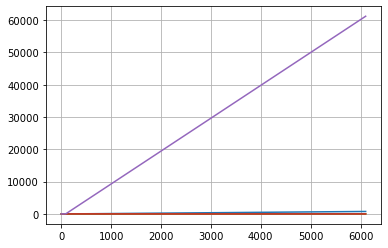

In [127]:
fig, ax = plt.subplots()

for i in range(5):
    ax.plot(graph_nodes[:, i])


plt.grid(True)

    
plt.show()

Each point on the blue line represents an approximation obtained during the iteration process in the parameter_move function, where the x-coordinate is the value of the u parameter and the y-coordinate is the corresponding value of the lambda parameter.

The approximations converge to a fixed point, so the blue line will show a clear pattern of convergence towards that point. 

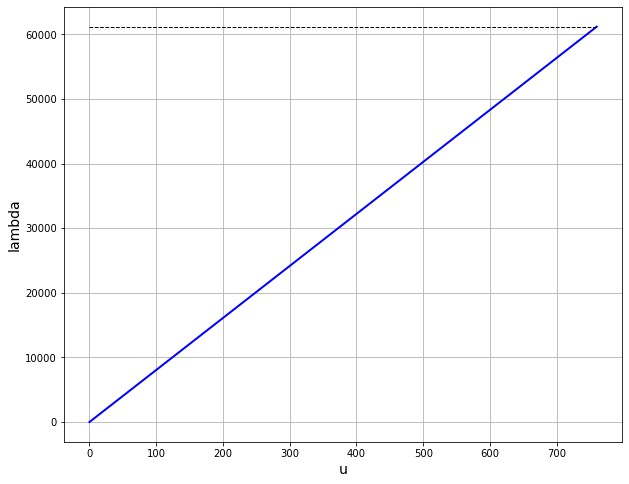

In [128]:
last_approx = graph_nodes[-1]

plt.figure(figsize=(10, 8))

plt.plot(graph_nodes[:, 0], graph_nodes[:, -1], color='blue', linewidth=2)

plt.plot([graph_nodes[0, 0], graph_nodes[-1, 0]], [last_approx[-1], last_approx[-1]], '--', color='black', linewidth=1)

plt.xlabel('u', fontsize=14)
plt.ylabel('lambda', fontsize=14)

plt.grid(True)

plt.show()

In [139]:
num_rows, num_columns = graph_nodes.shape

# Generate a color map for the scatter plots
colors = np.arange(num_rows)

# Plot each combination of columns against each other
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        plt.scatter(graph_nodes[:, i], graph_nodes[:, j], c=colors, cmap='viridis')
        plt.xlabel(f'Column {i+1}')
        plt.ylabel(f'Column {j+1}')
        plt.title(f'Scatter plot: Column {i+1} vs Column {j+1}')
        plt.colorbar(label='Data Point')
        plt.show()

ValueError: too many values to unpack (expected 2)

In [129]:
len(Frech_dets)

6103

In [130]:
len(graph_nodes)

6103

In [131]:
Frech_dets = np.array(Frech_dets)

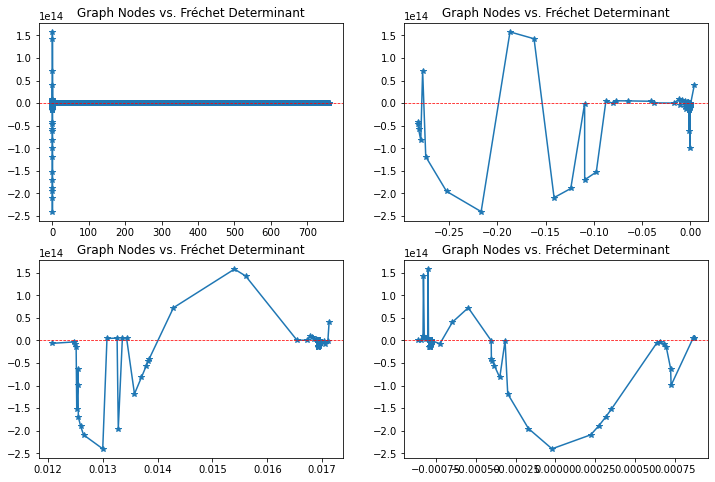

In [132]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axs[0, 1].plot(graph_nodes[np.argsort(graph_nodes[:, 1])][:, 1], Frech_dets[np.argsort(graph_nodes[:, 1])], marker="*")
axs[0, 1].set_title('Graph Nodes vs. Fréchet Determinant')
axs[0, 1].axhline(0, color='r', linestyle='--', linewidth=0.75) 

axs[0, 0].plot(graph_nodes[np.argsort(graph_nodes[:, 0])][:, 0], Frech_dets[np.argsort(graph_nodes[:, 0])], marker="*")
axs[0, 0].set_title('Graph Nodes vs. Fréchet Determinant')
axs[0, 0].axhline(0, color='r', linestyle='--', linewidth=0.75)  

axs[1, 0].plot(graph_nodes[np.argsort(graph_nodes[:, 2])][:, 2], Frech_dets[np.argsort(graph_nodes[:, 2])], marker="*")
axs[1, 0].set_title('Graph Nodes vs. Fréchet Determinant')
axs[1, 0].axhline(0, color='r', linestyle='--', linewidth=0.75)  

axs[1, 1].plot(graph_nodes[np.argsort(graph_nodes[:, 3])][:, 3], Frech_dets[np.argsort(graph_nodes[:, 3])], marker="*")
axs[1, 1].set_title('Graph Nodes vs. Fréchet Determinant')
axs[1, 1].axhline(0, color='r', linestyle='--', linewidth=0.75) 

plt.show()

TypeError: Invalid shape (10, 10, 10, 10) for image data

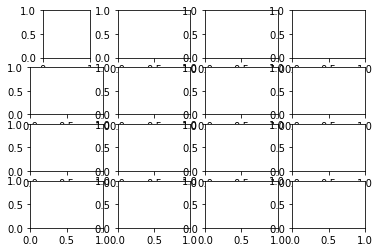

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Choose fixed values for four dimensions (you can modify this based on your array's dimensions)
fixed_dims = [0, 1, 2, 3]

# Create a subplot for each combination of the remaining two dimensions
fig, axs = plt.subplots(len(fixed_dims), len(fixed_dims))

# Iterate over the fixed dimensions and create plots
for i, dim1 in enumerate(fixed_dims):
    for j, dim2 in enumerate(fixed_dims):
        # Extract the 2D slice from the 6D array
        slice_2d = graph_nodes[:, :, :, :, dim1, dim2]
        
        # Plot the 2D slice
        axs[i, j].imshow(slice_2d)
        axs[i, j].set_title(f'Dimensions {dim1} vs {dim2}')

# Add a colorbar for reference
fig.colorbar(axs[0, 0].imshow(slice_2d))

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [133]:
eigenvals = np.array(eigenvals)

In [134]:
len(graph_nodes[:,0])

6103

In [135]:
len(eigenvals)

6103

/Users/ksenialysanuk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ksenialysanuk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


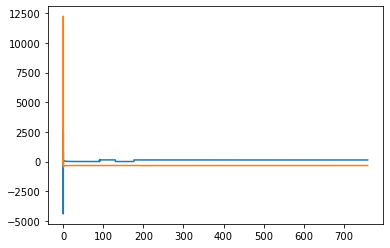

In [136]:
plt.plot(graph_nodes[:,0], eigenvals[:,0])
plt.plot(graph_nodes[:,0], eigenvals[:,1])